## Machine Learning Project Analysis - Phase 2: Exploratory Data Analysis (EDA) and Validation

Here is an analysis and explanation of the second part of your Machine Learning project, focusing on **Exploratory Data Analysis (EDA) and Validation**.

---

### Introduction

**Phase 2: Exploratory Data Analysis (EDA) and Validation** is the stage where a thorough examination of the data is conducted after the initial cleaning process. The goal is to confirm the structural integrity and extract preliminary business insights.

The primary objective of this phase is to ensure that the prepared data (saved in the `best_dataset_clean_2.1.pkl` file) is suitable for ML modeling, and to identify patterns, anomalies, and relationships between variables. The dataset examined at this stage contained 128,996 records and 29 columns.

---

### Methodology and Results

The EDA work was divided into three main types of analysis:

1.  **Data Loading and Structure Validation:**
    * The cleaned data was reloaded using the **Pickle** file (`best_dataset_clean_2.1.pkl`).
    * A **Validation Check** was performed, confirming that critical columns had minimal missing values (NA) and correct data types (e.g., proper date formats and numeric standards).
    * Initial analysis of numerical variables showed that the average sales amount (`amount`) was approximately **648.56** (prior to handling missing/infinite values).

2.  **Automated Profiling:**
    * Specialized libraries such as `ydata-profiling` and `sweetviz` were used to generate comprehensive, automated HTML reports.
    * These reports allowed for automatic diagnosis of data quality issues, examination of feature distributions, and identification of **initial correlations** among all features.

3.  **Visual Analysis and Key Findings:**
    * Manual visual analysis was performed on core business metrics, such as the distribution of the sales `Amount` and the quantity (`Qty`) by `Category`.
    * **Result 1 (Relationships):** An automated correlation matrix was generated, covering **93 features**, which helped identify **collinearity issues** that must be addressed during the feature selection phase.
    * **Result 2 (Business Insight):** Visual analysis confirmed that the "Western Dress" category accounted for the highest sales volume, suggesting it should be a focal point for future predictive modeling.

---

### Conclusion

The EDA phase successfully confirmed the integrity of the data following the initial cleaning. By using both automated tools and manual analysis, **preliminary business insights** and **feature validation** were obtained.

The insights gained during this phase lay a vital foundation for continued work:

* **Focus on High-Demand Apparel:** Confirmation that the **Western Dress** category leads in sales allows for the allocation of modeling resources to the behavior of this specific category.
* **Readiness for Feature Selection:** The identification of collinearity issues via the automated correlation matrix prepares the ground for the next stage, where the most influential and independent features will be chosen for model building.
* **Handling Outliers and Missing Data:** Findings such as remaining missing values (like in `amount`) and `inf` values in `unit_price` indicate the need for further cleaning and outlier treatment before model training.

# EDA using reporting libraries

In [11]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

In [12]:
df = pd.read_pickle("best_dataset_clean_2.1.pkl")

In [13]:
df.shape

(129002, 29)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129002 entries, 0 to 130425
Data columns (total 29 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   date                  129002 non-null  datetime64[ns]
 1   fulfilment            129002 non-null  category      
 2   ship-service-level    129002 non-null  category      
 3   category              129002 non-null  category      
 4   size                  129002 non-null  category      
 5   asin                  129002 non-null  string        
 6   pcs                   129001 non-null  category      
 7   currency              121204 non-null  string        
 8   amount                121204 non-null  float64       
 9   ship-state            128969 non-null  string        
 10  ship-postal-code      128969 non-null  Int64         
 11  ship-country          128969 non-null  category      
 12  b2b                   129002 non-null  boolean       
 13  day 

# Data Protocol

In [15]:
from itertools import zip_longest

# Identify column types by dtype
numeric_cols = df.select_dtypes(include=['int64', 'Int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include='category').columns.tolist()
string_cols = df.select_dtypes(include=['string', 'object']).columns.tolist()
boolean_cols = df.select_dtypes(include=['bool', 'boolean']).columns.tolist()

# Build a combined summary table for column types
columns_summary = pd.DataFrame(
    list(zip_longest(numeric_cols, categorical_cols, string_cols, boolean_cols)),
    columns=['Numeric Columns', 'Categorical Columns', 'String Columns', 'Boolean Columns']
)

# Display the summary with empty cells filled as blank
display(columns_summary.fillna(""))


Numeric Columns  Categorical Columns    String Columns     \
0            amount          fulfilment                 asin   
1  ship-postal-code  ship-service-level             currency   
2               day            category           ship-state   
3             stock                size            design_no   
4        unit_price                 pcs       ship-city_norm   
5                          ship-country  category_stock_norm   
6                                 month           color_norm   
7                               weekday                        
8                                status                        
9                                season                        

     Boolean Columns     
0                   b2b  
1               weekend  
2  fulfilment_by_amazon  
3        amazon_channel  
4         has_promotion  
5      seller_easy_ship  
6                        
7                        
8                        
9

Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


#General information report

In [16]:
import pandas as pd

# Define numeric-relevant types only for safe min/max calculations
relevant_types = ['int64', 'Int64', 'float64']

# Create an ExcelWriter to save multiple sheets into Amazon_Data.xlsx
# Using 'with' ensures the file is properly closed after writing
with pd.ExcelWriter("Amazon_Data.xlsx") as writer:

    # 1. Data types of all columns
    df.dtypes.to_excel(writer, sheet_name='data_type')

    # 2. Maximum values (numeric columns only — safely converted)
    df_numeric = df.select_dtypes(include=relevant_types).apply(pd.to_numeric, errors='coerce')
    df_max = df_numeric.max()
    df_max.to_excel(writer, sheet_name='max')

    # 3. Minimum values (numeric columns only — safely converted)
    df_min = df_numeric.min()
    df_min.to_excel(writer, sheet_name='min')

    # 4. Missing value counts per column
    df.isnull().sum(axis=0).to_excel(writer, sheet_name='NA')

    # 5. Number of unique values per column
    df.nunique().to_excel(writer, sheet_name='unique')

# The Excel file is now saved with all 5 summary sheets.


# Descriptive Statistics

Automated reports

In [17]:
!pip install autoviz --quiet

In [18]:
import pandas as pd
import numpy as np
from autoviz.AutoViz_Class import AutoViz_Class

# =======================================================
# 1. DataFrame normalization: targeted handling of missing values (Null)
# =======================================================
df_cleaned = df.copy()

# A. Replace pd.NA and ±inf with np.nan across the entire frame
#    (avoids 'boolean value of NA is ambiguous' errors)
df_cleaned = df_cleaned.replace(pd.NA, np.nan)
df_cleaned = df_cleaned.replace([np.inf, -np.inf], np.nan)

# B. Type-specific handling
for col in df_cleaned.columns:

    # 1. Numeric columns (float, int, Int64)
    #    i = integer, u = unsigned, f = float → cast to standard float64
    if df_cleaned[col].dtype.kind in 'iuf':
        df_cleaned[col] = df_cleaned[col].astype(np.float64)

    # 2. String/Categorical columns (object, category, string[python], etc.)
    elif df_cleaned[col].dtype.kind in 'O' or 'string' in str(df_cleaned[col].dtype) or 'category' in str(df_cleaned[col].dtype):

        # a. Default fill value for NA/NaN
        fill_val = 'MISSING_CATEGORY'

        # b. Convert to str and fillna BEFORE converting to category
        #    (ensures fillna works, then we cast to category)
        df_cleaned[col] = df_cleaned[col].astype(str).fillna(fill_val)

        # c. Convert to categorical dtype
        df_cleaned[col] = df_cleaned[col].astype('category')

    # 3. Boolean columns (boolean, bool)
    elif df_cleaned[col].dtype.kind in 'b':
        # Fill missing values (if any) with False
        df_cleaned[col] = df_cleaned[col].fillna(False)


In [19]:
# =======================================================
# 2. Run AutoViz using the cleaned DataFrame only
# =======================================================
AV = AutoViz_Class()
report = AV.AutoViz(
    filename="",
    dfte=df_cleaned,  # *** must use df_cleaned here ***
    verbose=1
)


Output hidden; open in https://colab.research.google.com to view.

# EDA - Explenatory Data Analysis

In [20]:
# Descriptive Statistics
df.describe()

date                  amount      ship-postal-code  \
count                         129002  121204.000000         128969.0    
mean   2022-05-12 11:43:42.824452352     648.557393    463977.372624    
min              2022-03-31 00:00:00       0.000000         110001.0    
25%              2022-04-20 00:00:00     449.000000         382421.0    
50%              2022-05-10 00:00:00     605.000000         500033.0    
75%              2022-06-04 00:00:00     788.000000         600024.0    
max              2022-06-29 00:00:00    5584.000000         989898.0    
std                              NaN     281.193381    191471.003626    

            day           stock      unit_price  
count  129002.000000  128781.000000   121178.0   
mean       14.925179      69.209394        inf   
min         1.000000       0.000000        0.0   
25%         7.000000       5.000000      459.0   
50%        15.000000      15.000000      646.0   
75%        22.000000      69.000000      885.0   
max        31.000000    1234.000000        inf   
std         8.743228     143.976905        NaN

In [21]:
import matplotlib.pyplot as plt
import seaborn as sb

# Target Value

Categorial 2 classes

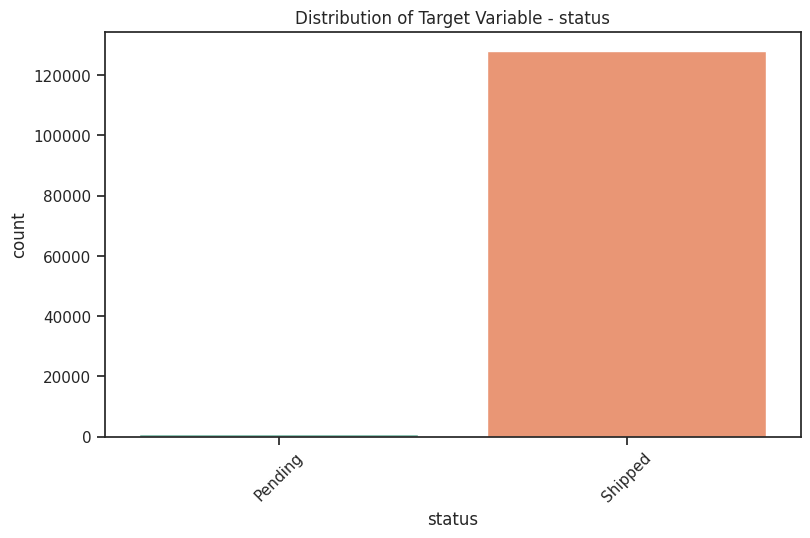

In [22]:
# ==============================================
# Target Variable Distribution - status
# ==============================================
plt.figure(figsize=(8,5))
sb.countplot(x="status", data=df, palette="Set2")
plt.title("Distribution of Target Variable - status")
plt.xticks(rotation=45)
plt.show()


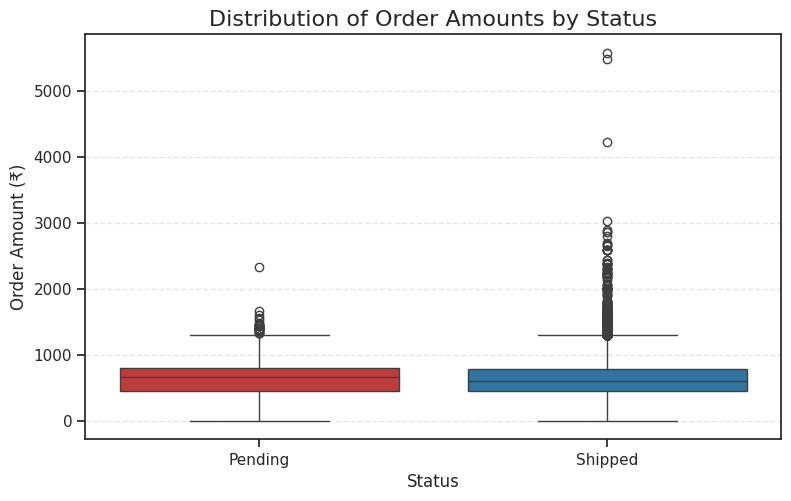

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Note: This boxplot visualizes the distribution of order amounts by shipment status.
# - 'Shipped' orders are colored blue (#1f77b4).
# - 'Pending' orders are colored red (#d62728).
# - If other statuses (e.g., 'Unshipped', 'Cancelled') exist in df['status'],
#   seaborn will raise an error since they are missing from the palette dictionary.
# - Consider adding them to the palette if needed.
# - Grid lines (dashed) help visualize medians across categories.

plt.figure(figsize=(8, 5))
sns.boxplot(
    x='status',
    y='amount',
    data=df,
    palette={'Shipped': '#1f77b4', 'Pending': '#d62728'}
)

plt.title("Distribution of Order Amounts by Status", fontsize=16)
plt.xlabel("Status")
plt.ylabel("Order Amount (₹)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


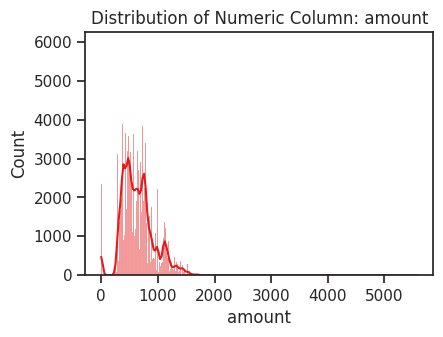

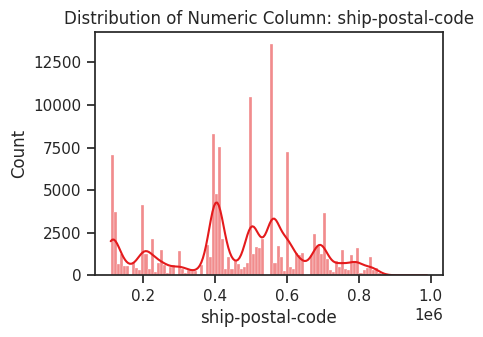

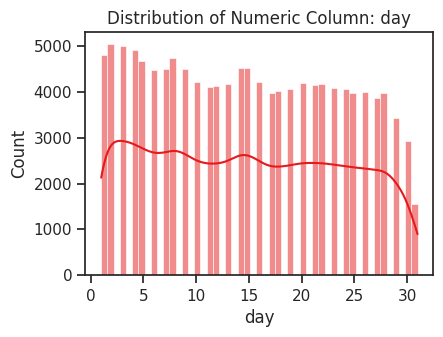

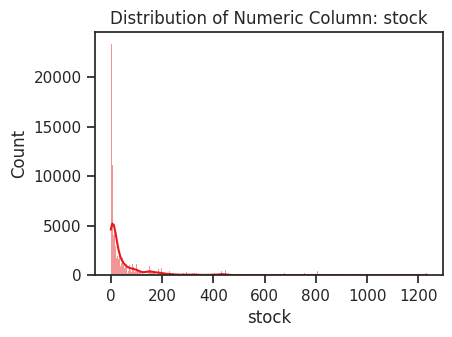

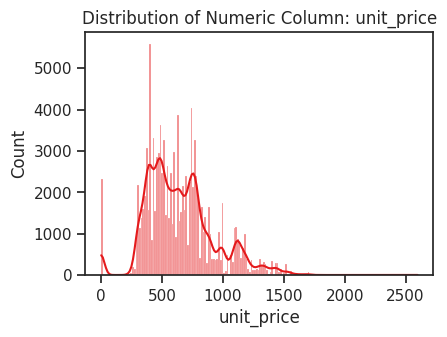

In [24]:
# ==============================================
# Numeric Columns Visualization
# ==============================================
import numpy as np

numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    plt.figure(figsize=(4,3))
    sb.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of Numeric Column: {col}")
    plt.show()


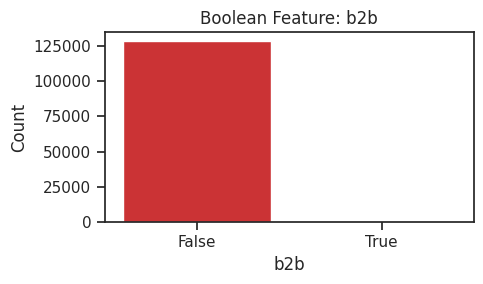

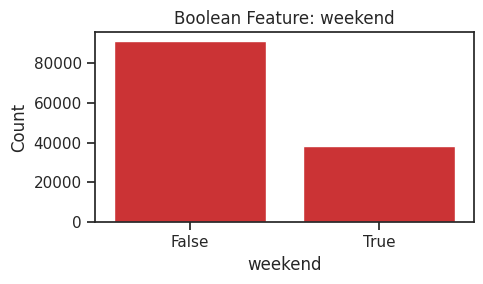

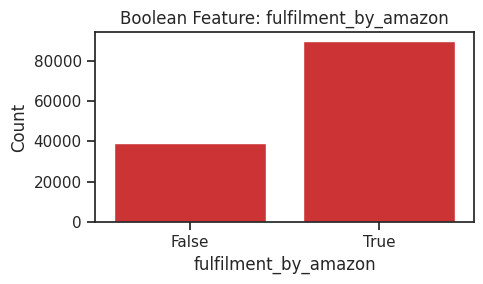

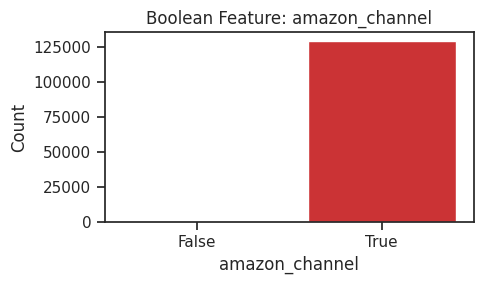

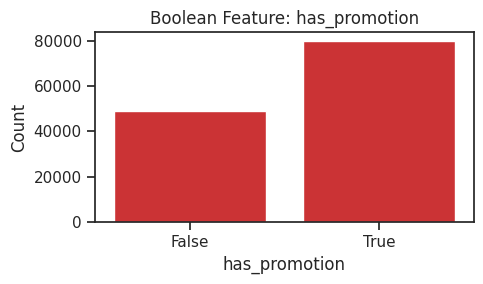

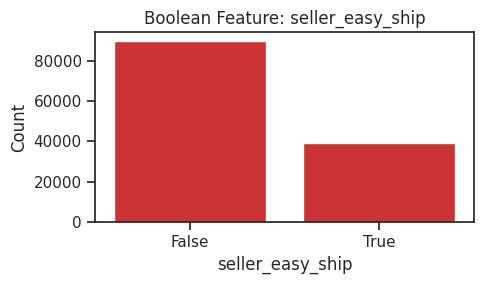

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

# === 1) Clean base (your block, with a small guard for np/pd already above) ===
if 'df_cleaned' not in locals() and 'df_cleaned' not in globals():
    df_cleaned = df.copy().replace(pd.NA, np.nan)
    # Normalize pandas nullable boolean dtype to pure bool
    bool_cols_full = df_cleaned.select_dtypes(include=["bool", "boolean"]).columns
    for col in bool_cols_full:
        df_cleaned[col] = df_cleaned[col].fillna(False).astype(bool)
else:
    pass

df_to_use = df_cleaned

# === 2) Define boolean_cols ===
# Option A: Only columns with a boolean data type
boolean_cols = df_to_use.select_dtypes(include=["bool", "boolean"]).columns.tolist()

# (Optional) Option B: Extended detection — identify binary-like columns that are not real booleans
# Example: 0/1, 'yes'/'no', 'true'/'false', 'y'/'n'
if not boolean_cols:
    candidates = []
    for c in df_to_use.columns:
        s = df_to_use[c]
        # Skip continuous numeric columns
        if pd.api.types.is_numeric_dtype(s):
            uniq = pd.unique(s.dropna())
            # Numeric binary 0/1
            if set(pd.Series(uniq).astype(float, errors='ignore')) <= {0, 1}:
                candidates.append(c)
        else:
            # Common textual binary values
            s_norm = s.astype("string").str.strip().str.lower()
            uniq = set(s_norm.dropna().unique())
            yesno = {"yes","no"}
            truefalse = {"true","false"}
            yn = {"y","n"}
            if len(uniq) <= 3 and (uniq <= yesno or uniq <= truefalse or uniq <= yn or uniq <= {"0","1"}):
                candidates.append(c)

    # Soft conversion to boolean for text-based candidates
    for c in candidates:
        s = df_to_use[c]
        if not pd.api.types.is_bool_dtype(s):
            s_norm = s.astype("string").str.strip().str.lower()
            mapped = s_norm.map({
                "true": True, "yes": True, "y": True, "1": True,
                "false": False, "no": False, "n": False, "0": False
            })
            # If conversion succeeds for most values — accept it
            if mapped.notna().mean() >= 0.9:
                df_to_use[c] = mapped.fillna(False).astype(bool)

    # Final update after conversions
    boolean_cols = df_to_use.select_dtypes(include=["bool", "boolean"]).columns.tolist()

# === 3) Safety: If no boolean-like columns are found, exit gracefully ===
if not boolean_cols:
    print("No boolean-like columns found to plot.")
else:
    # === 4) Plot ===
    for col in boolean_cols:
        plt.figure(figsize=(5, 3))
        sb.countplot(x=col, data=df_to_use)
        plt.title(f"Boolean Feature: {col}")
        plt.xlabel(col)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()


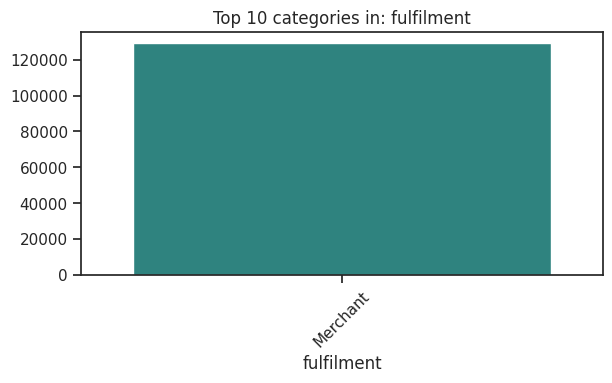

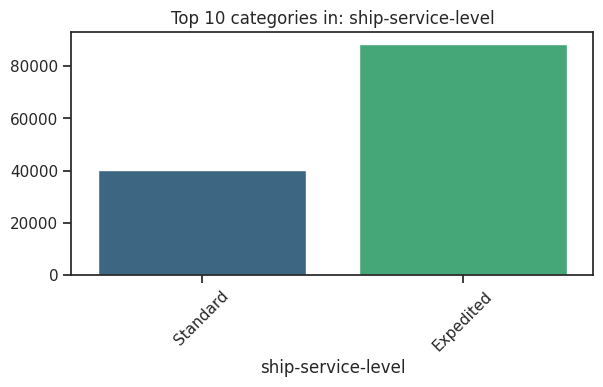

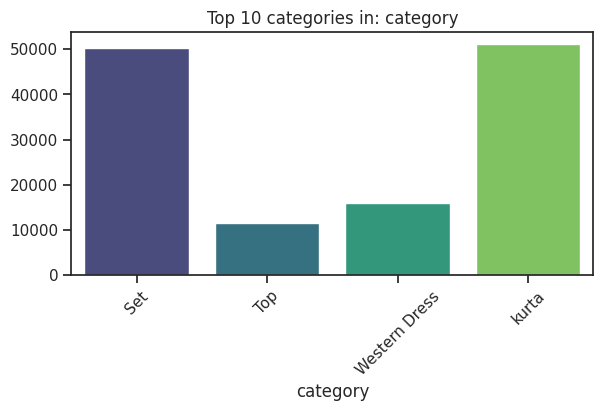

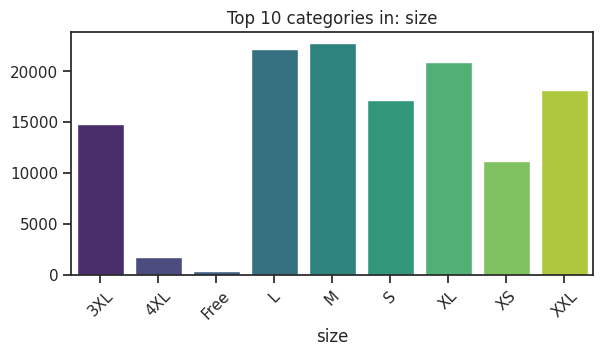

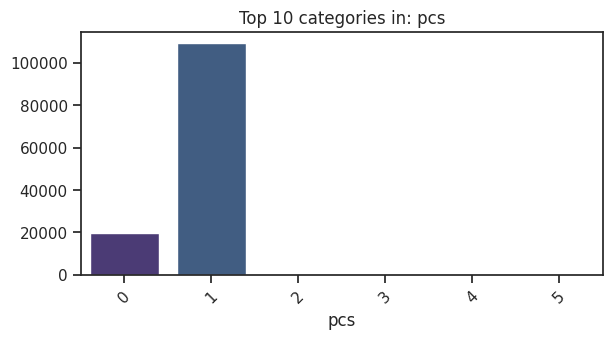

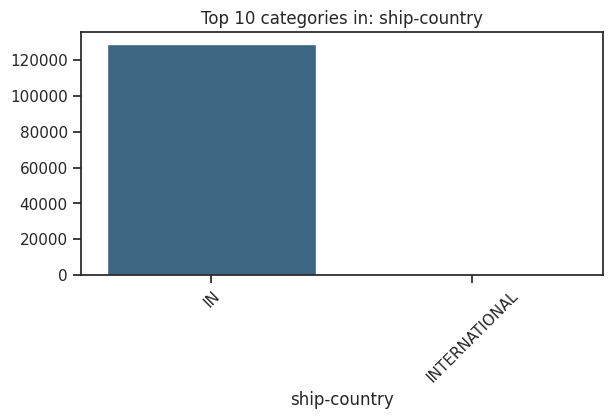

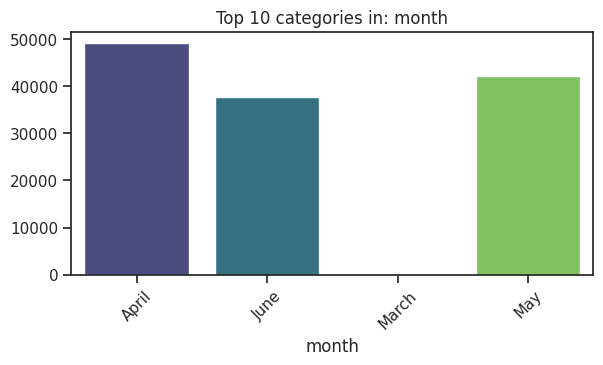

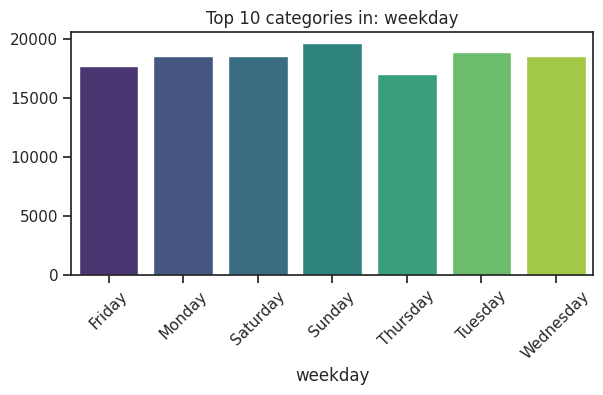

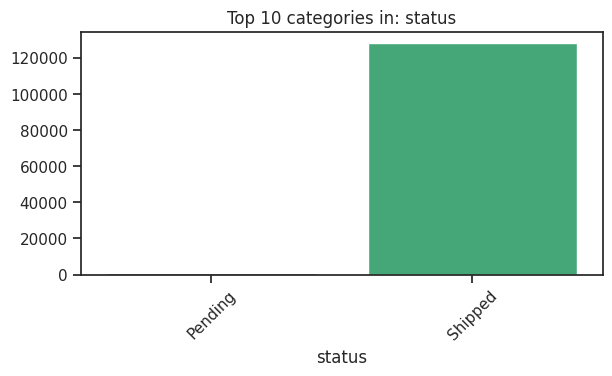

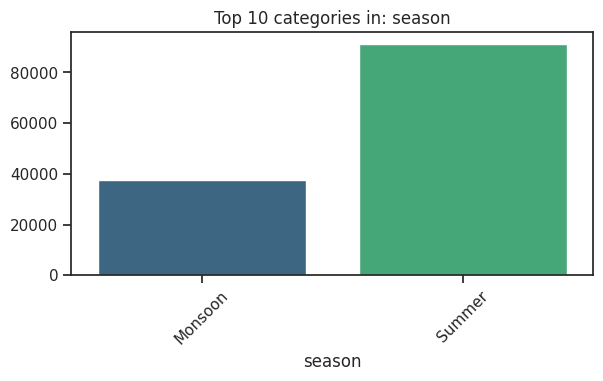

In [26]:
# ==============================================
# Categorical Columns Visualization
# ==============================================
cat_cols = df.select_dtypes(include=["object", "category"]).columns
for col in cat_cols:
    plt.figure(figsize=(6,3))
    top_vals = df[col].value_counts().head(10)
    sb.barplot(x=top_vals.index, y=top_vals.values, palette="viridis")
    plt.title(f"Top 10 categories in: {col}")
    plt.xticks(rotation=45)
    plt.show()


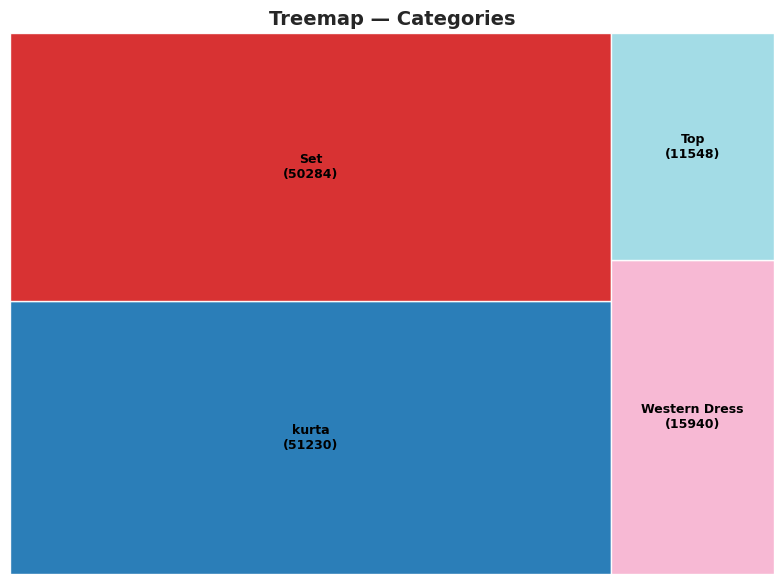

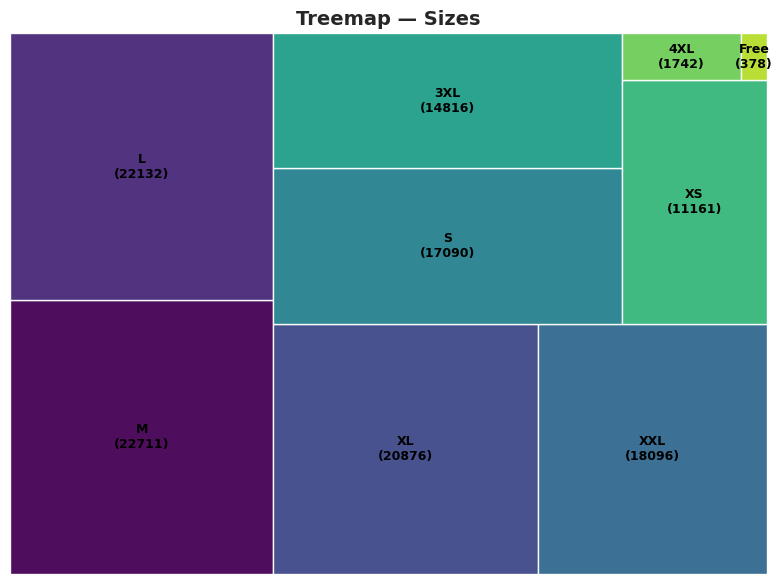

In [27]:
#==========================================
#Two Treemaps: Category and Size
#==========================================
import pandas as pd
import matplotlib.pyplot as plt
!pip install squarify
import squarify

MIN_COUNT=1

required={"category","size"}
missing=required-set(df.columns)
if missing:
    raise ValueError(f"Missing required columns:{sorted(missing)}")

work=df.copy()
work["category"]=work["category"].astype("string").fillna("Unknown").str.strip()
work["size"]=work["size"].astype("string").fillna("Unknown").str.strip()

#---Aggregate counts---
cat_counts=(work.groupby("category",dropna=False)
    .size().reset_index(name="count")
    .sort_values("count",ascending=False))
cat_counts=cat_counts[cat_counts["count"]>=MIN_COUNT].reset_index(drop=True)

size_counts=(work.groupby("size",dropna=False)
    .size().reset_index(name="count")
    .sort_values("count",ascending=False))
size_counts=size_counts[size_counts["count"]>=MIN_COUNT].reset_index(drop=True)

if cat_counts.empty or size_counts.empty:
    raise ValueError("No data to plot after cleaning.")

#---Labels---
cat_counts["label"]=cat_counts["category"].astype(str)+"\n("+cat_counts["count"].astype(int).astype(str)+")"
size_counts["label"]=size_counts["size"].astype(str)+"\n("+size_counts["count"].astype(int).astype(str)+")"

#---Color maps---
cmap_cat=plt.cm.get_cmap("tab20",max(2,min(20,len(cat_counts))))
cat_colors=[cmap_cat(i/len(cat_counts))for i in range(len(cat_counts))]

cmap_size=plt.cm.viridis
size_colors=[cmap_size(i/len(size_counts))for i in range(len(size_counts))]

#---1) Treemap for Categories---
plt.figure(figsize=(8,6))
squarify.plot(
    sizes=cat_counts["count"].values,
    label=cat_counts["label"].values,
    color=cat_colors,
    alpha=0.95,
    pad=False,
    text_kwargs={"fontsize":9,"weight":"bold","color":"black"}
)
plt.title("Treemap — Categories",fontsize=14,weight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()

#---2) Treemap for Sizes---
plt.figure(figsize=(8,6))
squarify.plot(
    sizes=size_counts["count"].values,
    label=size_counts["label"].values,
    color=size_colors,
    alpha=0.95,
    pad=False,
    text_kwargs={"fontsize":9,"weight":"bold","color":"black"}
)
plt.title("Treemap — Sizes",fontsize=14,weight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()


In [28]:
# Convert numeric columns before performing calculations
df["amount"] = pd.to_numeric(df["amount"], errors="coerce")
df["pcs"] = pd.to_numeric(df["pcs"], errors="coerce")

# Perform groupby aggregation by category
category_stats = (
    df.groupby("category", observed=True)
    .agg(
        total_amount=("amount", "sum"),     # total sales amount per category
        average_amount=("amount", "mean"),  # average sales amount per category
        total_units=("pcs", "sum")          # total number of units sold
    )
    .round(2)
    .sort_values("total_amount", ascending=False)  # sort descending by total amount
)

# Display summarized statistics per category
print(category_stats)


               total_amount  average_amount  total_units
category                                                
Set             39204124.03      833.39        42607.0  
kurta           22230685.12      463.22        43580.0  
Western Dress   11366740.67      751.57        13623.0  
Top              5806200.48      525.64        10101.0  


# Categorial Data

# Histograms for continues numbers

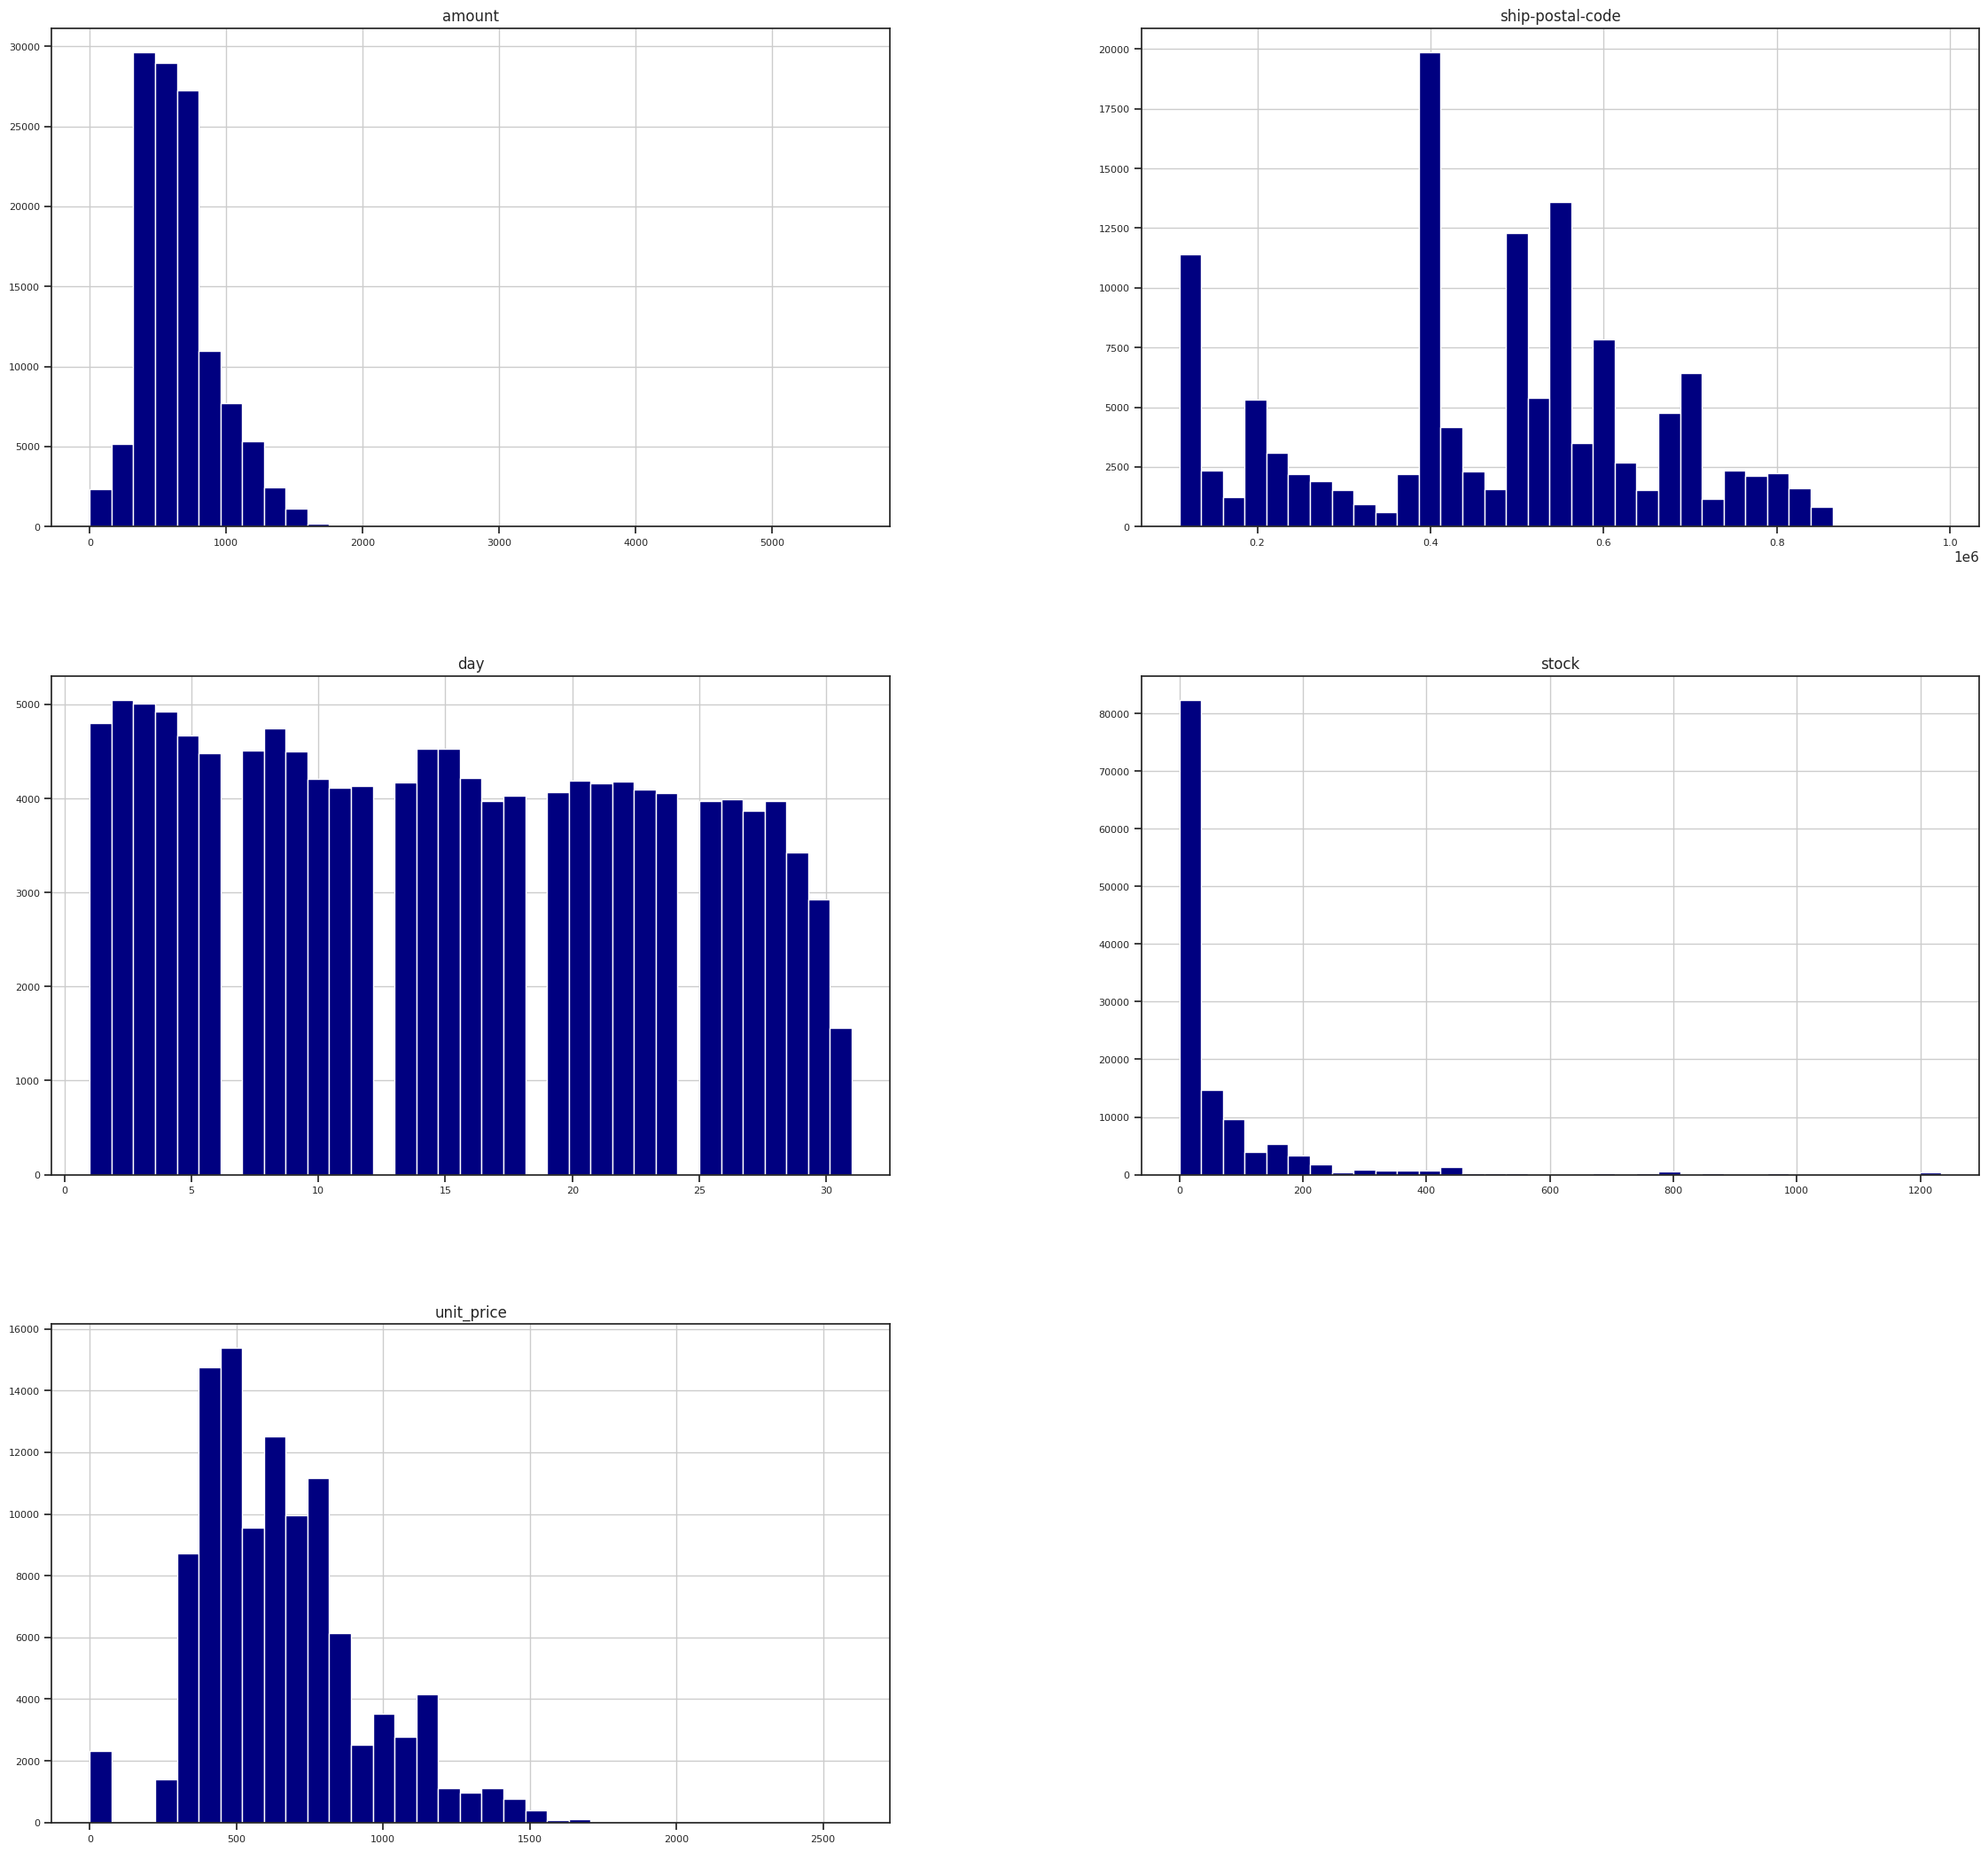

In [29]:
# Assumption: df_cleaned is the cleaned DataFrame we prepared earlier
df_to_use = df_cleaned

# 1. Select only numeric columns from the DataFrame
numeric_df = df_to_use.select_dtypes(include=np.number)

# 2. Plot histograms for all numeric columns
# The semicolon at the end suppresses extra Matplotlib output in notebooks
numeric_df.hist(
    figsize=(25, 25),  # set overall figure size
    bins=35,           # number of bins per histogram
    xlabelsize=8,      # X-axis label size
    ylabelsize=8,      # Y-axis label size
    color="navy"       # histogram color
);


# Skewness

In [30]:
# Define a function to highlight skewness values visually
def highlight(cell_value):
    highlight = 'background-color: mediumspringgreen;'  # for highly positive skew (> 1)
    negative = 'background-color: hotpink;'             # for highly negative skew (< -1)
    default = ''                                        # no formatting otherwise
    if cell_value > 1:
        return highlight
    elif cell_value < -1:
        return negative
    else:
        return default

# Compute skewness for each numeric column and apply conditional highlighting
pd.DataFrame(numeric_df.skew(), columns=['skewness']) \
  .sort_values(by='skewness', ascending=False) \
  .style.applymap(highlight)


Most continus data are normaly distributed

# Correlation

In [31]:
#The Pearson correlation measures the linear relationship between two continuous variables

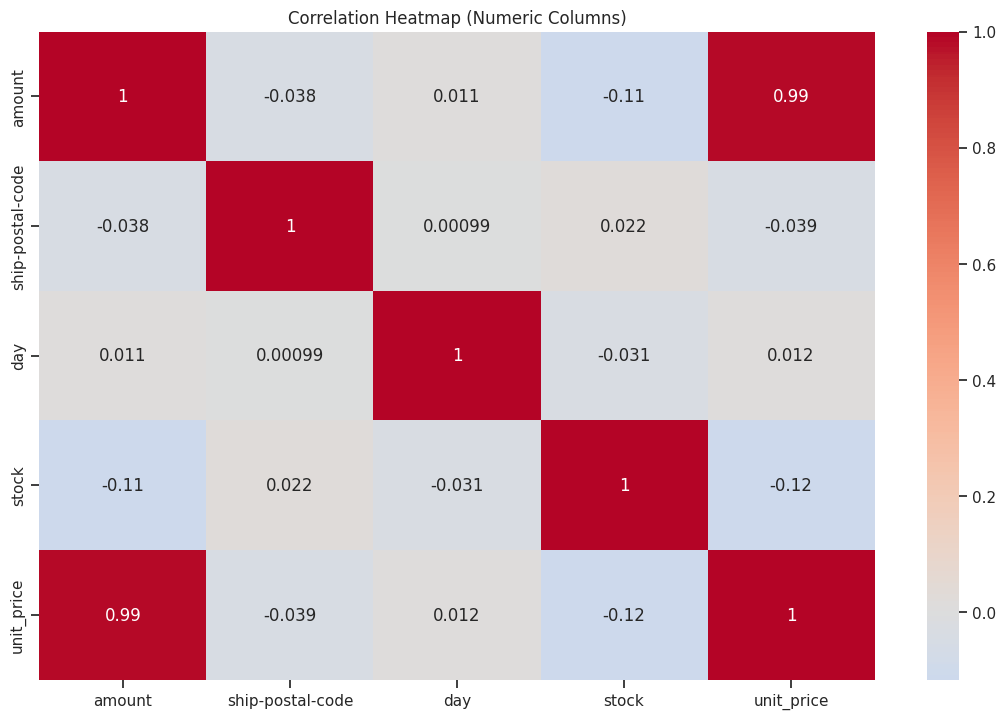

In [32]:
# ==============================================
# 9. Correlation Heatmap for Numeric Variables
# ==============================================
plt.figure(figsize=(12,8))
sb.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Numeric Columns)")
plt.show()

In [33]:
df.corr(numeric_only=True)


pcs     amount   ship-postal-code     b2b    \
pcs                   1.000000  0.033261     -0.015167      0.016821   
amount                0.033261  1.000000     -0.038202      0.015706   
ship-postal-code     -0.015167 -0.038202      1.000000     -0.035650   
b2b                   0.016821  0.015706     -0.035650      1.000000   
day                  -0.021695  0.011321      0.000986      0.006725   
weekend               0.014898  0.003169     -0.015699     -0.003861   
stock                -0.002444 -0.111257      0.021787     -0.002718   
fulfilment_by_amazon  0.065883  0.004918      0.001846     -0.005090   
amazon_channel        0.072371       NaN      0.011304      0.002557   
has_promotion         0.482507  0.126005      0.006115      0.002131   
seller_easy_ship     -0.065883 -0.004918     -0.001846      0.005090   
unit_price           -0.010095  0.986406     -0.039440      0.012501   

                         day     weekend    stock   fulfilment_by_amazon  \
pcs                  -0.021695  0.014898 -0.002444        0.065883         
amount                0.011321  0.003169 -0.111257        0.004918         
ship-postal-code      0.000986 -0.015699  0.021787        0.001846         
b2b                   0.006725 -0.003861 -0.002718       -0.005090         
day                   1.000000 -0.005531 -0.030787       -0.046386         
weekend              -0.005531  1.000000 -0.015081        0.003493         
stock                -0.030787 -0.015081  1.000000        0.132663         
fulfilment_by_amazon -0.046386  0.003493  0.132663        1.000000         
amazon_channel       -0.004357 -0.008399 -0.006941       -0.020526         
has_promotion         0.020517  0.012055 -0.082656       -0.278945         
seller_easy_ship      0.046386 -0.003493 -0.132663       -1.000000         
unit_price            0.011505  0.002747 -0.115699       -0.000904         

                      amazon_channel  has_promotion  seller_easy_ship  \
pcs                      0.072371       0.482507        -0.065883       
amount                        NaN       0.126005        -0.004918       
ship-postal-code         0.011304       0.006115        -0.001846       
b2b                      0.002557       0.002131         0.005090       
day                     -0.004357       0.020517         0.046386       
weekend                 -0.008399       0.012055        -0.003493       
stock                   -0.006941      -0.082656        -0.132663       
fulfilment_by_amazon    -0.020526      -0.278945        -1.000000       
amazon_channel           1.000000       0.039529         0.020526       
has_promotion            0.039529       1.000000         0.278945       
seller_easy_ship         0.020526       0.278945         1.000000       
unit_price                    NaN       0.140921         0.000904       

                      unit_price  
pcs                   -0.010095   
amount                 0.986406   
ship-postal-code      -0.039440   
b2b                    0.012501   
day                    0.011505   
weekend                0.002747   
stock                 -0.115699   
fulfilment_by_amazon  -0.000904   
amazon_channel              NaN   
has_promotion          0.140921   
seller_easy_ship       0.000904   
unit_price             1.000000

<Axes: >

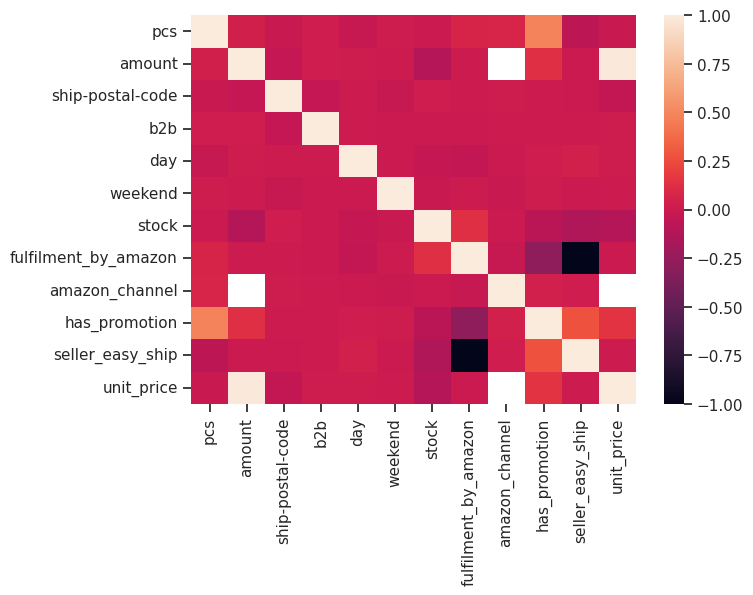

In [34]:
sb.heatmap(df.corr(numeric_only=True))

In [35]:
# Calculate Spearman correlation between all numeric columns
# Spearman method measures monotonic relationships (rank-based correlation)
df.corr(method='spearman', numeric_only=True)



pcs     amount   ship-postal-code     b2b    \
pcs                   1.000000  0.019408     -0.014886      0.015727   
amount                0.019408  1.000000     -0.045585      0.012664   
ship-postal-code     -0.014886 -0.045585      1.000000     -0.036546   
b2b                   0.015727  0.012664     -0.036546      1.000000   
day                  -0.020875  0.017339      0.000477      0.007168   
weekend               0.014526  0.005004     -0.015368     -0.003861   
stock                -0.004644 -0.072592      0.034483     -0.004918   
fulfilment_by_amazon  0.067220 -0.002178      0.002816     -0.005090   
amazon_channel        0.072972       NaN      0.025468      0.002557   
has_promotion         0.485560  0.140728      0.015588      0.002131   
seller_easy_ship     -0.067220  0.002178     -0.002816      0.005090   
unit_price           -0.011229  0.995645     -0.046398      0.011877   

                         day     weekend    stock   fulfilment_by_amazon  \
pcs                  -0.020875  0.014526 -0.004644        0.067220         
amount                0.017339  0.005004 -0.072592       -0.002178         
ship-postal-code      0.000477 -0.015368  0.034483        0.002816         
b2b                   0.007168 -0.003861 -0.004918       -0.005090         
day                   1.000000 -0.005766 -0.008331       -0.049113         
weekend              -0.005766  1.000000 -0.017373        0.003493         
stock                -0.008331 -0.017373  1.000000        0.201609         
fulfilment_by_amazon -0.049113  0.003493  0.201609        1.000000         
amazon_channel       -0.004604 -0.008399 -0.007683       -0.020526         
has_promotion         0.021121  0.012055 -0.110768       -0.278945         
seller_easy_ship      0.049113 -0.003493 -0.201609       -1.000000         
unit_price            0.017598  0.005198 -0.076597       -0.009069         

                      amazon_channel  has_promotion  seller_easy_ship  \
pcs                      0.072972       0.485560        -0.067220       
amount                        NaN       0.140728         0.002178       
ship-postal-code         0.025468       0.015588        -0.002816       
b2b                      0.002557       0.002131         0.005090       
day                     -0.004604       0.021121         0.049113       
weekend                 -0.008399       0.012055        -0.003493       
stock                   -0.007683      -0.110768        -0.201609       
fulfilment_by_amazon    -0.020526      -0.278945        -1.000000       
amazon_channel           1.000000       0.039529         0.020526       
has_promotion            0.039529       1.000000         0.278945       
seller_easy_ship         0.020526       0.278945         1.000000       
unit_price                    NaN       0.156030         0.009069       

                      unit_price  
pcs                   -0.011229   
amount                 0.995645   
ship-postal-code      -0.046398   
b2b                    0.011877   
day                    0.017598   
weekend                0.005198   
stock                 -0.076597   
fulfilment_by_amazon  -0.009069   
amazon_channel              NaN   
has_promotion          0.156030   
seller_easy_ship       0.009069   
unit_price             1.000000

   size  total_amount  avg_unit_price
4     M   13906754.37    548.167188  
3     L   13234886.19    538.695554  
6    XL   12464965.86    537.886089  
8   XXL   10636288.45    533.434295  
5     S   10629210.18    558.360094  
0   3XL    9157147.68    563.302713  
7    XS    7022375.20    560.277394  
1   4XL    1350929.60    718.014351  
2  Free     205192.77    483.740741  


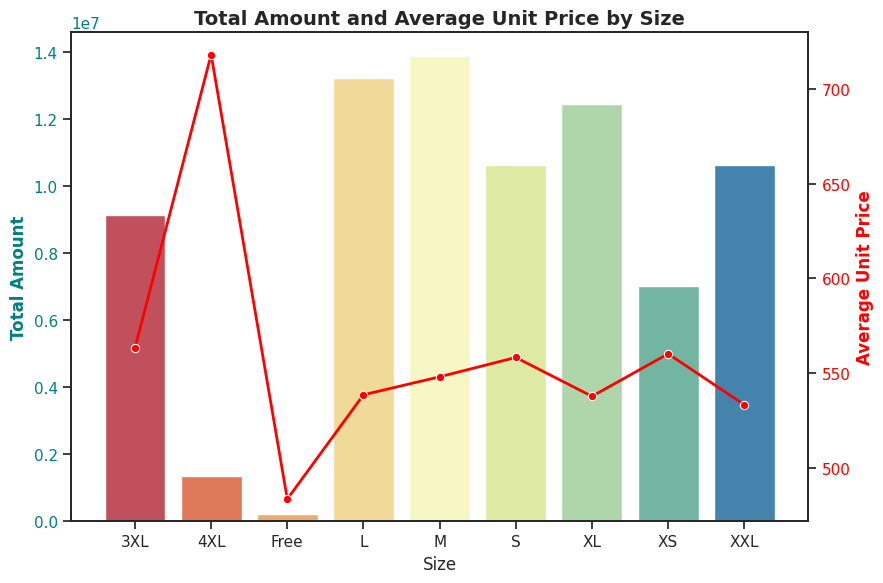

In [36]:
#==========================================
#Total Amount and Unit Price by Size
#==========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure required columns exist
required = {"size", "amount", "pcs"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"DataFrame must include columns {sorted(missing)}")

# Compute unit price safely
df["unit_price"] = df["amount"] / df["pcs"].replace(0, pd.NA)
df["unit_price"] = df["unit_price"].fillna(0)

# Group by size: total amount and average unit price
size_summary = (
    df.groupby("size", dropna=False)
      .agg(total_amount=("amount", "sum"), avg_unit_price=("unit_price", "mean"))
      .reset_index()
      .sort_values("total_amount", ascending=False)
)

# Show summary table
print(size_summary)

# Create figure
fig, ax1 = plt.subplots(figsize=(9,6))

# Barplot for total amount
sns.barplot(
    data=size_summary,
    x="size",
    y="total_amount",
    palette="Spectral",
    ax=ax1
)
ax1.set_xlabel("Size")
ax1.set_ylabel("Total Amount", color="teal", weight="bold")
ax1.tick_params(axis="y", labelcolor="teal")
ax1.set_title("Total Amount and Average Unit Price by Size", fontsize=14, weight="bold")

# Add secondary y-axis for average unit price
ax2 = ax1.twinx()
sns.lineplot(
    data=size_summary,
    x="size",
    y="avg_unit_price",
    color="red",
    marker="o",
    linewidth=2,
    ax=ax2
)
ax2.set_ylabel("Average Unit Price", color="red", weight="bold")
ax2.tick_params(axis="y", labelcolor="red")

# Improve readability
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


   has_promotion  unit_price
1       True      661.787037
0      False      365.970729


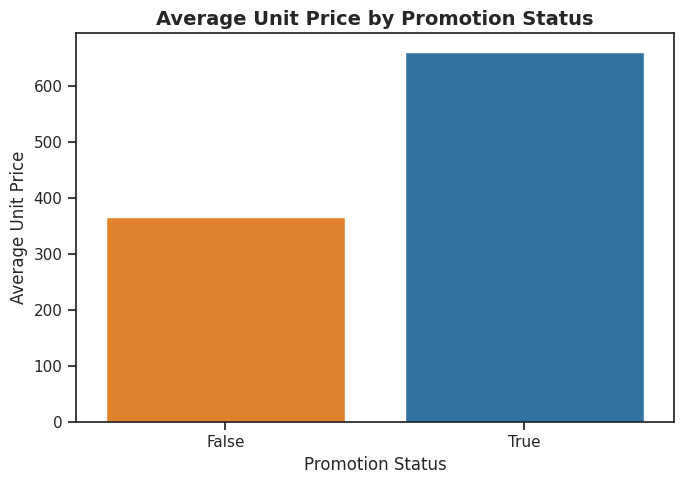

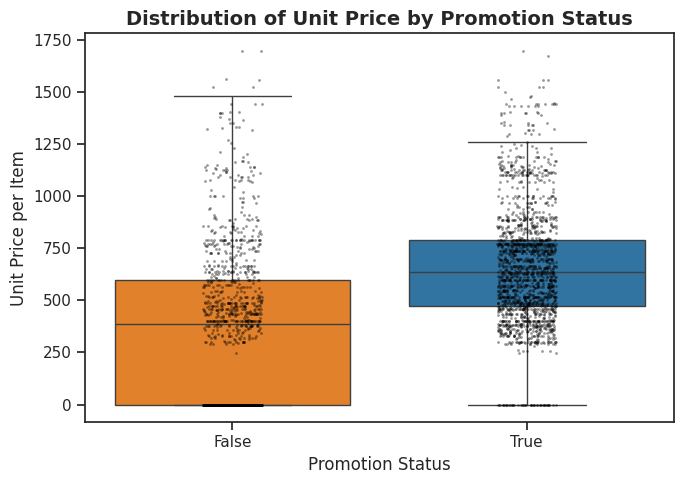

In [37]:
#==========================================
#Unit Price vs Promotion
#==========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure required columns exist
required = {"amount", "pcs", "has_promotion"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {sorted(missing)}")

# Compute unit price safely
df["unit_price"] = df["amount"] / df["pcs"].replace(0, pd.NA)
df["unit_price"] = df["unit_price"].fillna(0)

# Convert promotion column to readable form if needed
df["has_promotion"] = df["has_promotion"].map({1: "With Promotion", 0: "No Promotion"}).fillna(df["has_promotion"])

# Aggregate average unit price per promotion type
promo_price_summary = (
    df.groupby("has_promotion", dropna=False)["unit_price"]
      .mean()
      .reset_index()
      .sort_values("unit_price", ascending=False)
)

print(promo_price_summary)

# --- 1) Bar chart of average unit price ---
plt.figure(figsize=(7,5))
sns.barplot(
    data=promo_price_summary,
    x="has_promotion",
    y="unit_price",
    palette=["#ff7f0e", "#1f77b4"]
)
plt.title("Average Unit Price by Promotion Status", fontsize=14, weight="bold")
plt.xlabel("Promotion Status")
plt.ylabel("Average Unit Price")
plt.tight_layout()
plt.show()

# --- 2) Boxplot + Scatter for individual distribution ---
plt.figure(figsize=(7,5))
sns.boxplot(
    data=df,
    x="has_promotion",
    y="unit_price",
    palette=["#ff7f0e", "#1f77b4"],
    showfliers=False
)
sns.stripplot(
    data=df.sample(min(len(df), 3000)),  # sample for readability
    x="has_promotion",
    y="unit_price",
    color="black",
    size=2,
    alpha=0.4
)
plt.title("Distribution of Unit Price by Promotion Status", fontsize=14, weight="bold")
plt.xlabel("Promotion Status")
plt.ylabel("Unit Price per Item")
plt.tight_layout()
plt.show()


The chart you’re showing is a **boxplot + scatter (strip plot)** comparing **unit price per item** between two groups:

* **False → orders without promotion**
* **True → orders with promotion**

### 🔍 Interpretation

1. **Median (the horizontal line inside each box):**

   * The median unit price (middle 50%) is **higher for the “True” group (with promotion)** than for the “False” group.
   * That means items under promotion tend to have **higher average unit prices** overall.

2. **Boxes (IQR — Interquartile Range):**

   * The box shows where the middle 50% of values lie.
   * The “True” group (blue) is centered higher and tighter — unit prices are more consistent.
   * The “False” group (orange) has a wider spread — more variation in unit prices.

3. **Whiskers (vertical lines):**

   * Show the overall range (excluding extreme outliers).
   * Promotions (True) still cover a wide range, but most data is concentrated in a narrower band.

4. **Black dots (scatter overlay):**

   * Each dot = one observation (order).
   * You can see that even without promotion, some orders have high prices — but most cluster at lower values.

---

### 🧠 In summary:

* **“True” (with promotion)** → higher, more stable unit prices.
* **“False” (no promotion)** → lower median, wider variability.
* Counterintuitively, in your dataset, promotions don’t seem to reduce unit price — they’re likely applied to **premium products**, not as discounts.

Would you like me to show a numeric summary (mean, median, std, count) for both groups next to this plot for clarity?


<Figure size 1100x600 with 0 Axes>

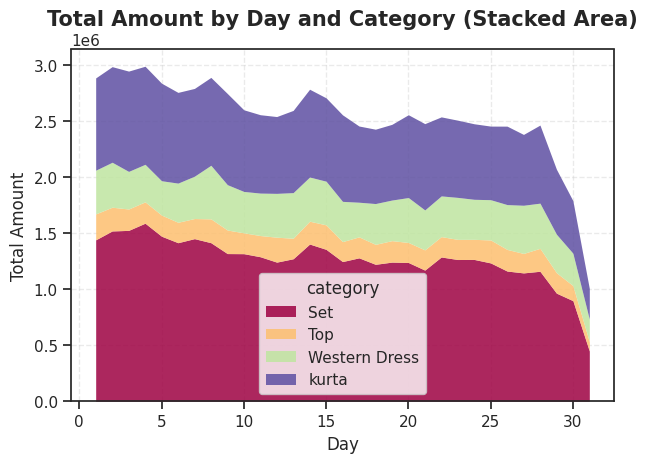

In [38]:
#==========================================
#Day vs Category — Amount Visualization
#==========================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check required columns
required = {"day", "category", "amount"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing columns: {sorted(missing)}")

# Group by day and category
day_cat_summary = (
    df.groupby(["day", "category"], dropna=False)["amount"]
      .sum()
      .reset_index()
      .sort_values("day")
)

# Pivot for matrix-style visualization
pivot = day_cat_summary.pivot(index="day", columns="category", values="amount").fillna(0)

# --- 1) Stacked area chart ---
plt.figure(figsize=(11,6))
pivot.plot(
    kind="area",
    stacked=True,
    alpha=0.85,
    cmap="Spectral",
    linewidth=0
)
plt.title("Total Amount by Day and Category (Stacked Area)", fontsize=15, weight="bold")
plt.xlabel("Day")
plt.ylabel("Total Amount")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()




#t-test

In [39]:
!pip install scipy
import scipy.stats as stats
import seaborn as sns


--- T-test (b2b vs amount) ---
T-statistic: -4.5920
P-value: 0.00001
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


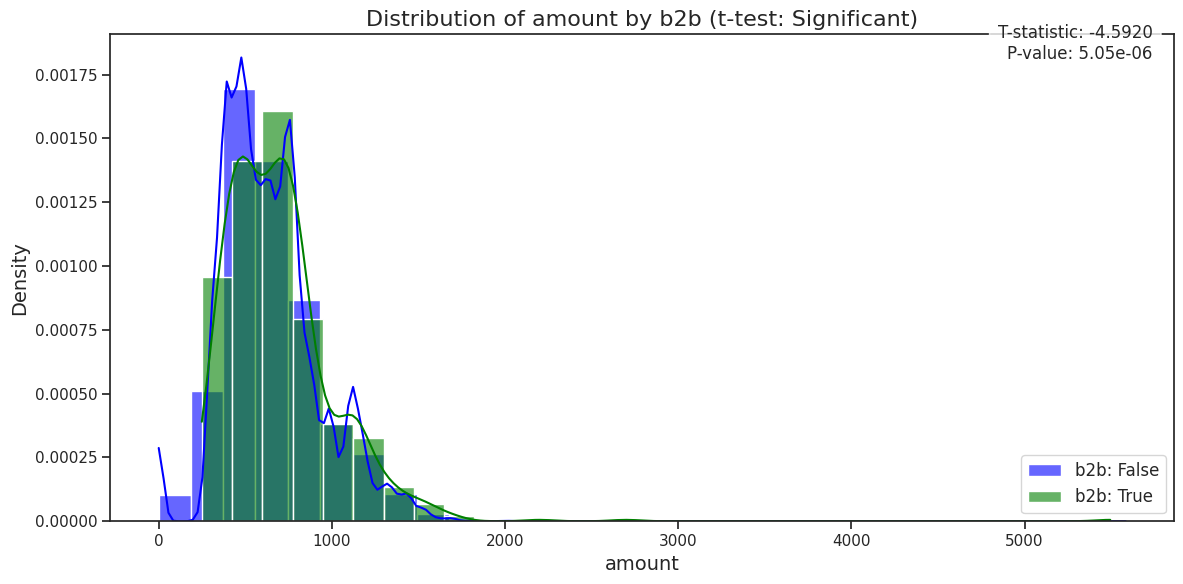


--- T-test (status vs amount) ---
T-statistic: -1.6536
P-value: 0.09854
Result: Not Significant difference in mean amount (P < 0.05)
--------------------------------------------------


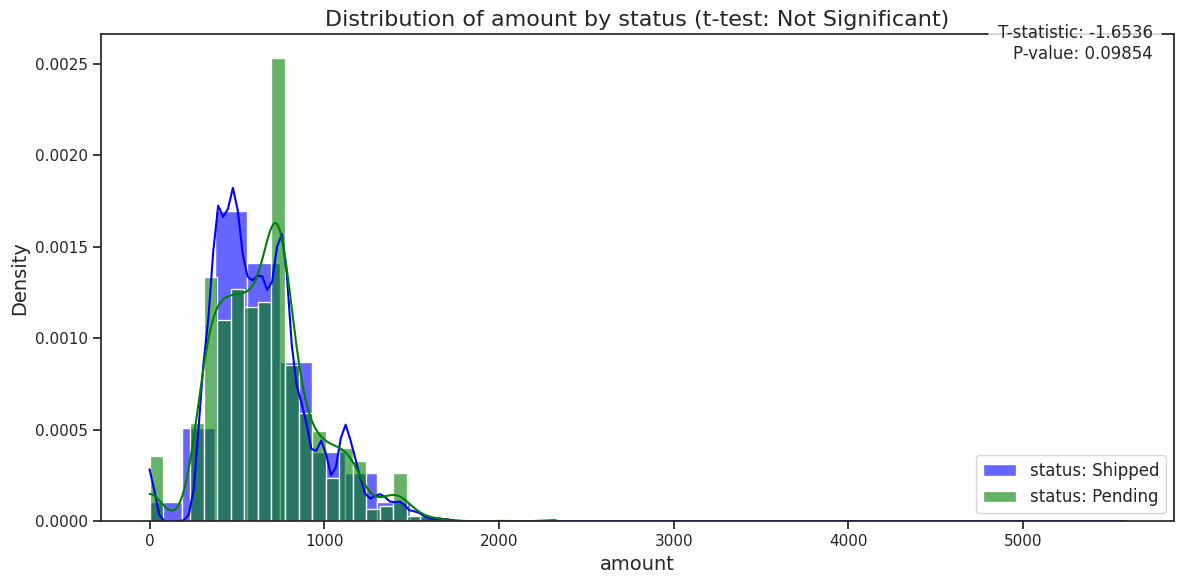

Skipping fulfilment: Found 1 unique categories (expected 2 for t-test).

--- T-test (ship-service-level vs amount) ---
T-statistic: -13.6308
P-value: 0.00000
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


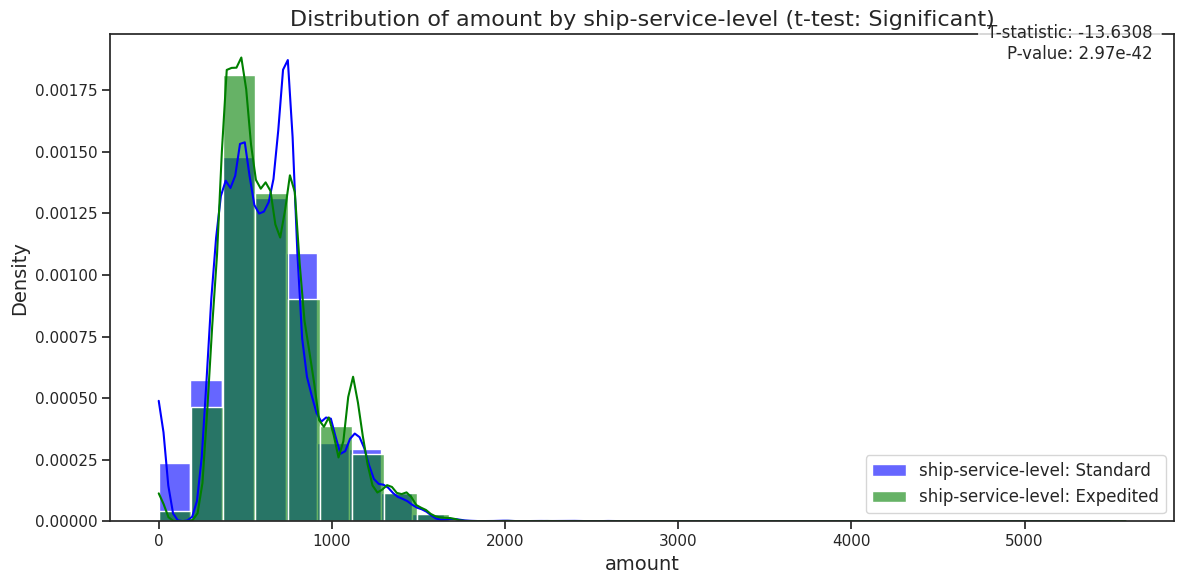


--- T-test (has_promotion vs amount) ---
T-statistic: 43.6728
P-value: 0.00000
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


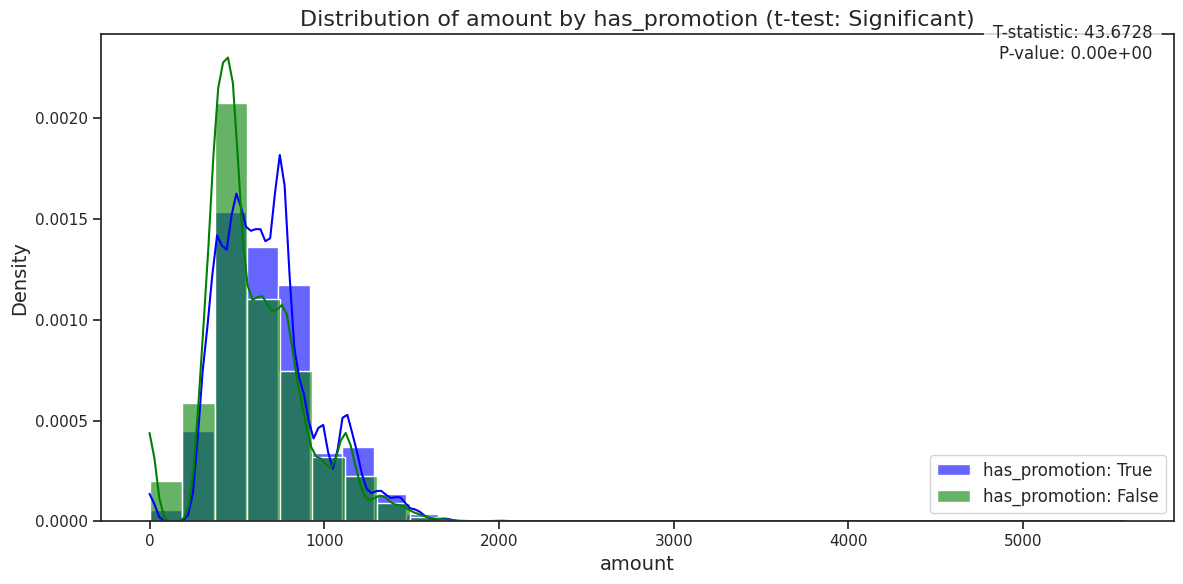


--- T-test (seller_easy_ship vs amount) ---
T-statistic: -1.7162
P-value: 0.08613
Result: Not Significant difference in mean amount (P < 0.05)
--------------------------------------------------


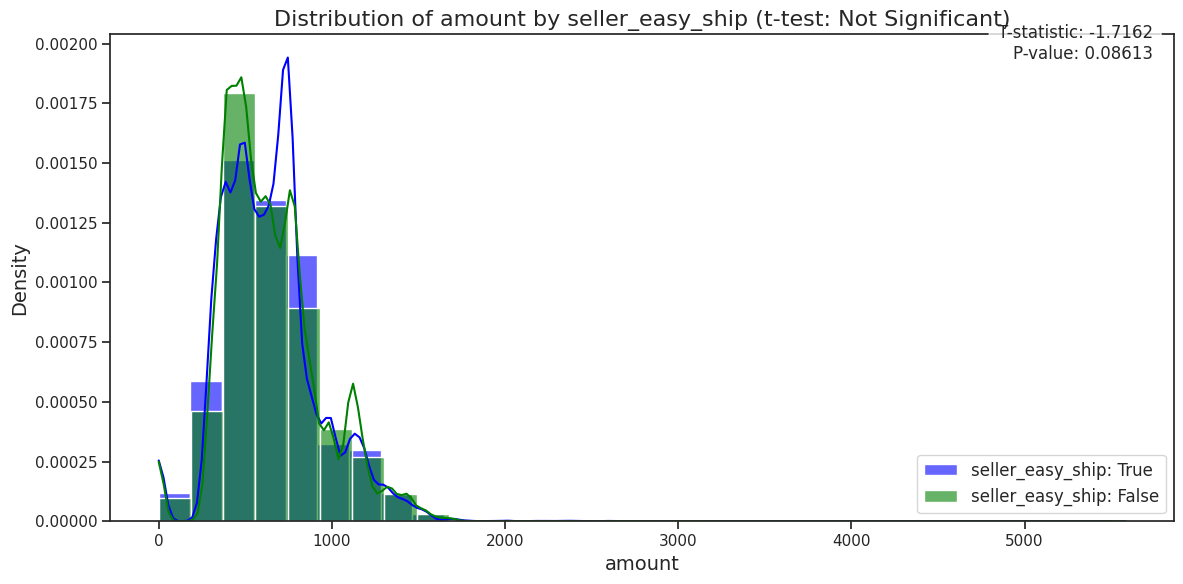

Skipping amazon_channel: Found 1 unique categories (expected 2 for t-test).

--- T-test (fulfilment_by_amazon vs amount) ---
T-statistic: -1.7162
P-value: 0.08613
Result: Not Significant difference in mean amount (P < 0.05)
--------------------------------------------------


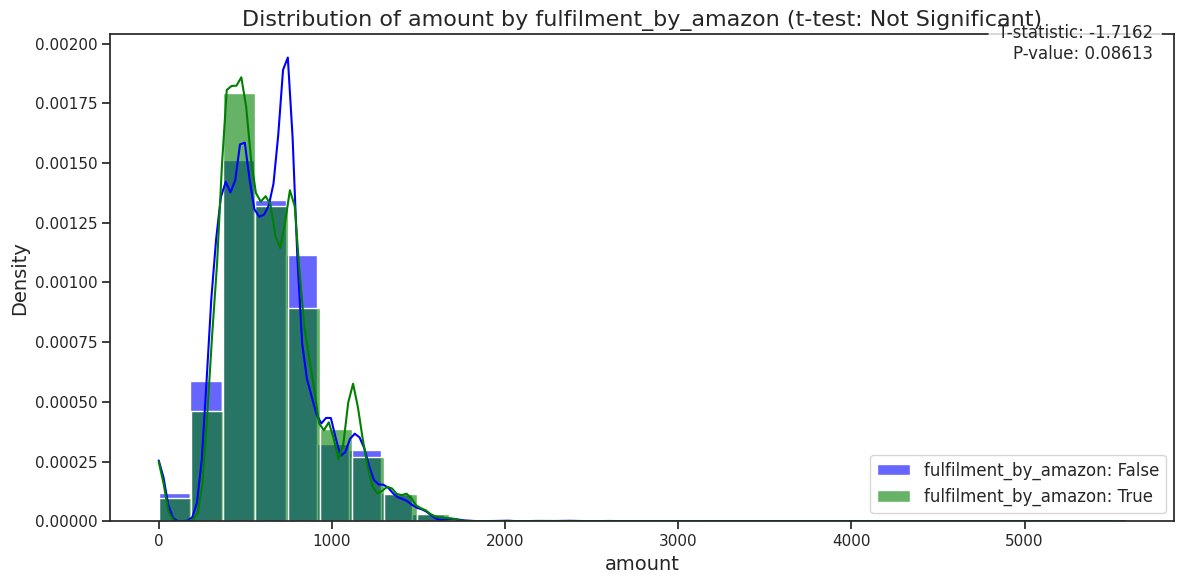

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

# -------------------------------------------------------------
# 1. Settings
# -------------------------------------------------------------
# Assumption: 'df' is your working DataFrame (loaded and ready)
df_to_use = df
TARGET_NUMERIC = "amount"
BINARY_COLS = [
    'b2b',
    'status',
    'fulfilment',
    'ship-service-level',
    'has_promotion',
    'seller_easy_ship',
    'amazon_channel',
    'fulfilment_by_amazon'
]

# 2. Build a subset without NA in the target column
# This ensures t-tests are computed on comparable samples
df_test = df_to_use.dropna(subset=[TARGET_NUMERIC])

# -------------------------------------------------------------
# 3. Function: run t-test and plot distributions
# -------------------------------------------------------------
def run_ttest_and_plot(df, numeric_col, binary_col):
    """Run an independent-samples t-test and plot histogram/KDE for a given binary column."""

    # Drop rows with NA in the binary column
    df_clean_specific = df.dropna(subset=[binary_col])

    # Detect the two categories
    categories = df_clean_specific[binary_col].unique()

    if len(categories) != 2:
        print(f"Skipping {binary_col}: Found {len(categories)} unique categories (expected 2 for t-test).")
        return

    # Explicitly unpack the two categories
    cat1, cat2 = list(categories)
    group1 = df_clean_specific[df_clean_specific[binary_col] == cat1][numeric_col]
    group2 = df_clean_specific[df_clean_specific[binary_col] == cat2][numeric_col]

    # Ensure sufficient sample size
    if len(group1) < 2 or len(group2) < 2:
        print(f"Skipping {binary_col}: Not enough samples in one or both groups.")
        return

    # Welch's t-test (unequal variances)
    t_stat, p_val = ttest_ind(group1, group2, equal_var=False)

    # Print results
    print(f"\n--- T-test ({binary_col} vs {numeric_col}) ---")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_val:.5f}")

    is_significant = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"Result: {is_significant} difference in mean {numeric_col} (P < 0.05)")
    print("-" * 50)

    # 4. Plot (Histogram + KDE)
    plt.figure(figsize=(12, 6))

    # Overlay both distributions
    sns.histplot(group1, kde=True, color='blue',  label=f'{binary_col}: {cat1}', bins=30, stat='density', alpha=0.6)
    sns.histplot(group2, kde=True, color='green', label=f'{binary_col}: {cat2}', bins=30, stat='density', alpha=0.6)

    # Titles and labels
    title = f'Distribution of {numeric_col} by {binary_col} (t-test: {is_significant})'
    plt.title(title, fontsize=16)
    plt.xlabel(numeric_col, fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.legend(fontsize=12)

    # Annotate with test statistics
    p_val_display = f"{p_val:.2e}" if p_val < 1e-5 else f"{p_val:.5f}"
    plt.text(
        0.98, 0.95,
        f'T-statistic: {t_stat:.4f}\nP-value: {p_val_display}',
        transform=plt.gca().transAxes,
        fontsize=12,
        ha='right',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5')
    )

    plt.tight_layout()
    plt.show()  # display the plot in notebook output

# -------------------------------------------------------------
# 5. Run over all binary columns
# -------------------------------------------------------------
for col in BINARY_COLS:
    run_ttest_and_plot(df_test, TARGET_NUMERIC, col)


# Anova

#F-statistic = Variance Between the groups/Variance within the groups


--- ANOVA (category vs amount) ---
F-statistic: 24123.4980
P-value: 0.00000
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


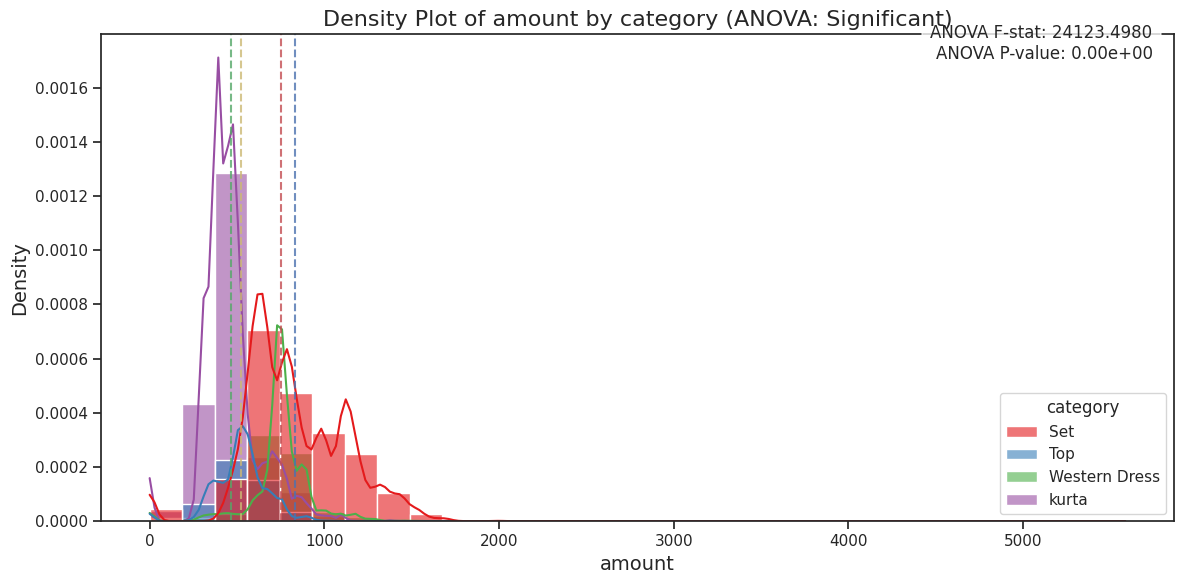


--- ANOVA (size vs amount) ---
F-statistic: 132.5839
P-value: 0.00000
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


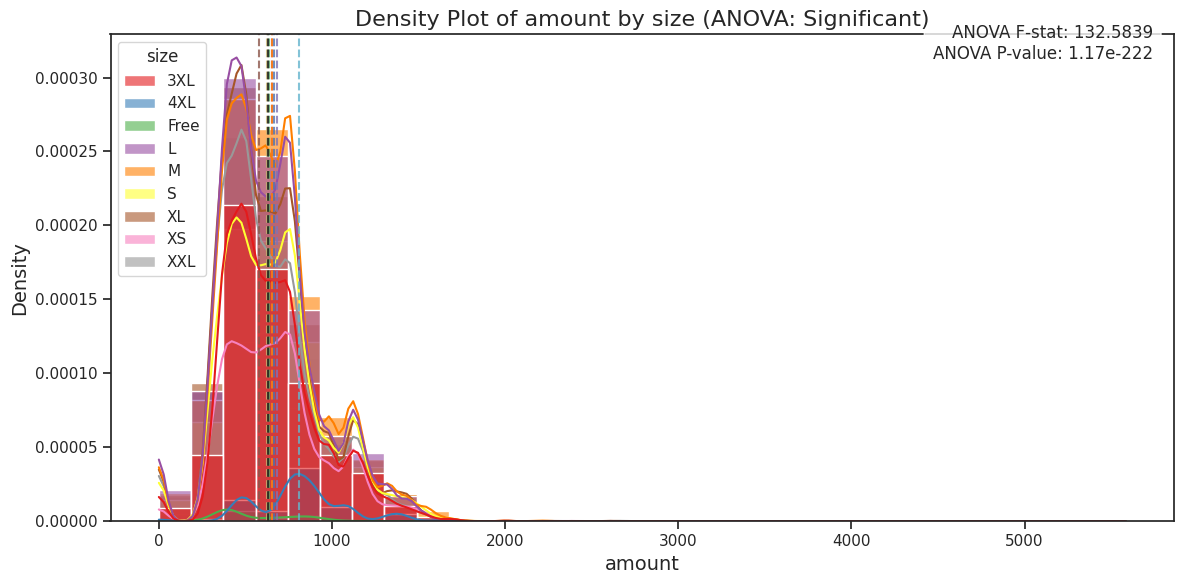

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# -------------------------------------------------------------
# 1. Settings
# -------------------------------------------------------------
# Assumption: 'df' is your working DataFrame
df_to_use = df
TARGET_NUMERIC = "amount"

# Categorical variables to test with ANOVA (expect ≥ 3 groups)
ANOVA_COLS = [
    'category',
    'size',
]

# 2. Build a subset without NA in the target column
df_test = df_to_use.dropna(subset=[TARGET_NUMERIC])

# -------------------------------------------------------------
# 3. Function: run ANOVA and draw a density plot
# -------------------------------------------------------------
def run_anova_and_density_plot(df, numeric_col, cat_col):
    """Run one-way ANOVA and plot density (hist + KDE) by the given categorical column."""

    # Drop rows with NA in the categorical column
    df_clean_specific = df.dropna(subset=[cat_col])

    # Get category levels
    categories = df_clean_specific[cat_col].unique()

    if len(categories) < 3:
        print(f"Skipping {cat_col}: Found only {len(categories)} unique categories (ANOVA requires >= 3).")
        return

    # Build groups for ANOVA
    groups = []
    for cat in categories:
        group_data = df_clean_specific[df_clean_specific[cat_col] == cat][numeric_col]
        if len(group_data) >= 2:
            groups.append(group_data)

    if len(groups) < 2:
        print(f"Skipping {cat_col}: Less than 2 valid groups found after data cleaning.")
        return

    # Run one-way ANOVA
    f_stat, p_val = f_oneway(*groups)

    # Print results
    print(f"\n--- ANOVA ({cat_col} vs {numeric_col}) ---")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_val:.5f}")

    is_significant = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"Result: {is_significant} difference in mean amount (P < 0.05)")
    print("-" * 50)

    # 4. Density plot (stacked histograms + KDE by category)
    plt.figure(figsize=(12, 6))
    sns.histplot(
        data=df_clean_specific,
        x=numeric_col,
        hue=cat_col,
        kde=True,          # overlay density curve
        stat='density',    # y-axis shows density
        alpha=0.6,
        bins=30,
        legend=True
    )

    # Optional: vertical dashed lines at each group's mean
    colors = ['r', 'b', 'g', 'y', 'm', 'c', 'k', 'tab:orange', 'tab:brown']
    for i, cat in enumerate(categories):
        mean_val = df_clean_specific[df_clean_specific[cat_col] == cat][numeric_col].mean()
        plt.axvline(mean_val, color=colors[i % len(colors)], linestyle='--', alpha=0.8)

    # Titles and labels
    title = f'Density Plot of {numeric_col} by {cat_col} (ANOVA: {is_significant})'
    plt.title(title, fontsize=16)
    plt.xlabel(numeric_col, fontsize=14)
    plt.ylabel('Density', fontsize=14)

    # Annotate with statistics
    p_val_display = f"{p_val:.2e}" if p_val < 0.00001 else f"{p_val:.5f}"
    plt.text(
        0.98, 0.95,
        f'ANOVA F-stat: {f_stat:.4f}\nANOVA P-value: {p_val_display}',
        transform=plt.gca().transAxes,
        fontsize=12,
        ha='right',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5')
    )

    plt.tight_layout()
    plt.show()

# -------------------------------------------------------------
# 5. Execute for all selected categorical variables
# -------------------------------------------------------------
for col in ANOVA_COLS:
    run_anova_and_density_plot(df_test, TARGET_NUMERIC, col)



--- ANOVA (category vs amount) ---
F-statistic: 24123.4980
P-value: 0.00000
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


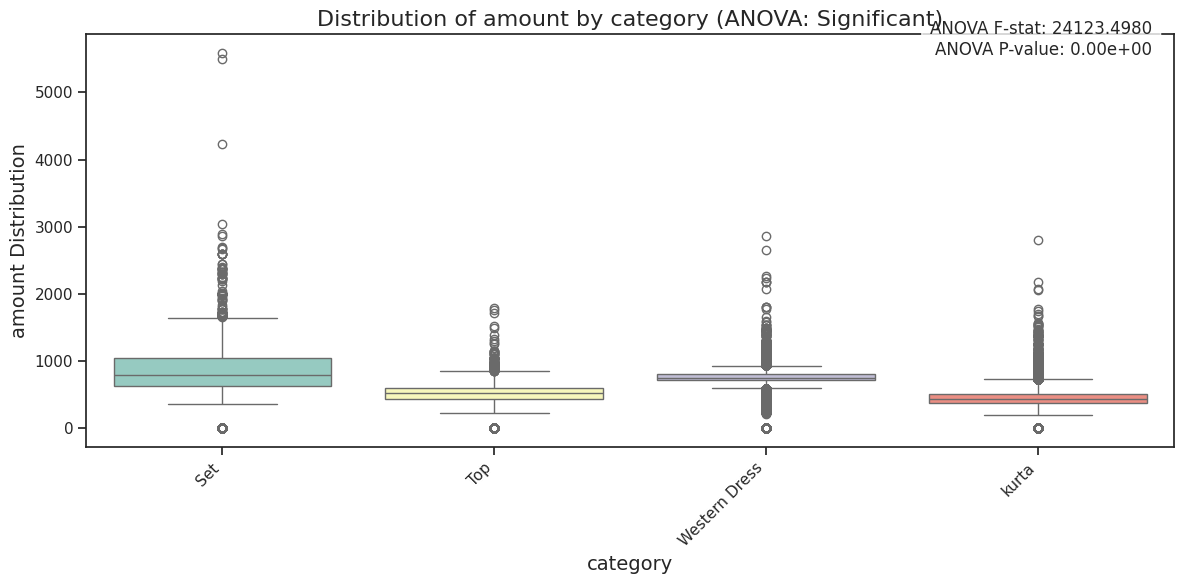


--- ANOVA (size vs amount) ---
F-statistic: 132.5839
P-value: 0.00000
Result: Significant difference in mean amount (P < 0.05)
--------------------------------------------------


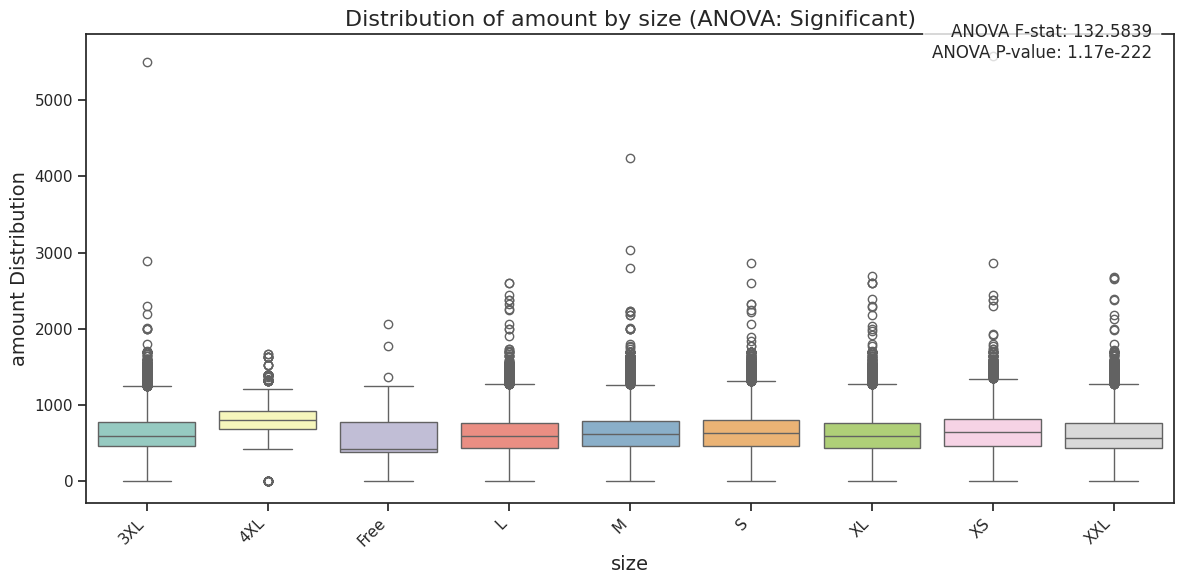

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

# -------------------------------------------------------------
# 1. Settings
# -------------------------------------------------------------
# Assumption: 'df' is your working DataFrame and is already loaded.
df_to_use = df
TARGET_NUMERIC = "amount"

# Categorical variables for ANOVA (expecting ≥ 3 groups each)
ANOVA_COLS = [
    'category',
    'size',
]

# 2. Build a subset without NA in the target column
df_test = df_to_use.dropna(subset=[TARGET_NUMERIC])

# -------------------------------------------------------------
# 3. Function to run ANOVA and draw a Box Plot
# -------------------------------------------------------------
def run_anova_and_plot(df, numeric_col, cat_col):
    """Run one-way ANOVA and plot a Box Plot for the given categorical column."""

    # Drop rows with NA in the categorical column
    df_clean_specific = df.dropna(subset=[cat_col])

    # Identify category levels present in the current data
    categories = df_clean_specific[cat_col].unique()

    # ANOVA requires at least 3 groups
    if len(categories) < 3:
        print(f"Skipping {cat_col}: Found only {len(categories)} unique categories (ANOVA requires >= 3).")
        return

    # Build per-category groups for ANOVA; ensure each has at least 2 samples
    groups = []
    for cat in categories:
        group_data = df_clean_specific[df_clean_specific[cat_col] == cat][numeric_col]
        if len(group_data) >= 2:
            groups.append(group_data)
        else:
            print(f"Warning: Category '{cat}' in {cat_col} has insufficient data for ANOVA.")

    if len(groups) < 2:
        print(f"Skipping {cat_col}: Less than 2 valid groups found after data cleaning.")
        return

    # Run one-way ANOVA across the groups
    f_stat, p_val = f_oneway(*groups)

    # Print results
    print(f"\n--- ANOVA ({cat_col} vs {numeric_col}) ---")
    print(f"F-statistic: {f_stat:.4f}")
    print(f"P-value: {p_val:.5f}")

    is_significant = "Significant" if p_val < 0.05 else "Not Significant"
    print(f"Result: {is_significant} difference in mean amount (P < 0.05)")
    print("-" * 50)

    # 4. Box Plot for visual comparison (median, IQR, and outliers)
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=cat_col, y=numeric_col, data=df_clean_specific, palette="Set3")

    # Titles and labels
    title = f'Distribution of {numeric_col} by {cat_col} (ANOVA: {is_significant})'
    plt.title(title, fontsize=16)
    plt.xlabel(cat_col, fontsize=14)
    plt.ylabel(f'{numeric_col} Distribution', fontsize=14)

    # Rotate category labels for readability
    plt.xticks(rotation=45, ha='right')

    # Annotate with ANOVA statistics on the plot
    p_val_display = f"{p_val:.2e}" if p_val < 0.00001 else f"{p_val:.5f}"
    plt.text(
        0.98, 0.95,
        f'ANOVA F-stat: {f_stat:.4f}\nANOVA P-value: {p_val_display}',
        transform=plt.gca().transAxes,
        fontsize=12,
        ha='right',
        bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5')
    )

    plt.tight_layout()
    plt.show()  # ensure the figure renders in notebook environments

# -------------------------------------------------------------
# 5. Execute for all selected categorical variables
# -------------------------------------------------------------
for col in ANOVA_COLS:
    run_anova_and_plot(df_test, TARGET_NUMERIC, col)


✅ 1) ANOVA לפי category

# CHI-Square

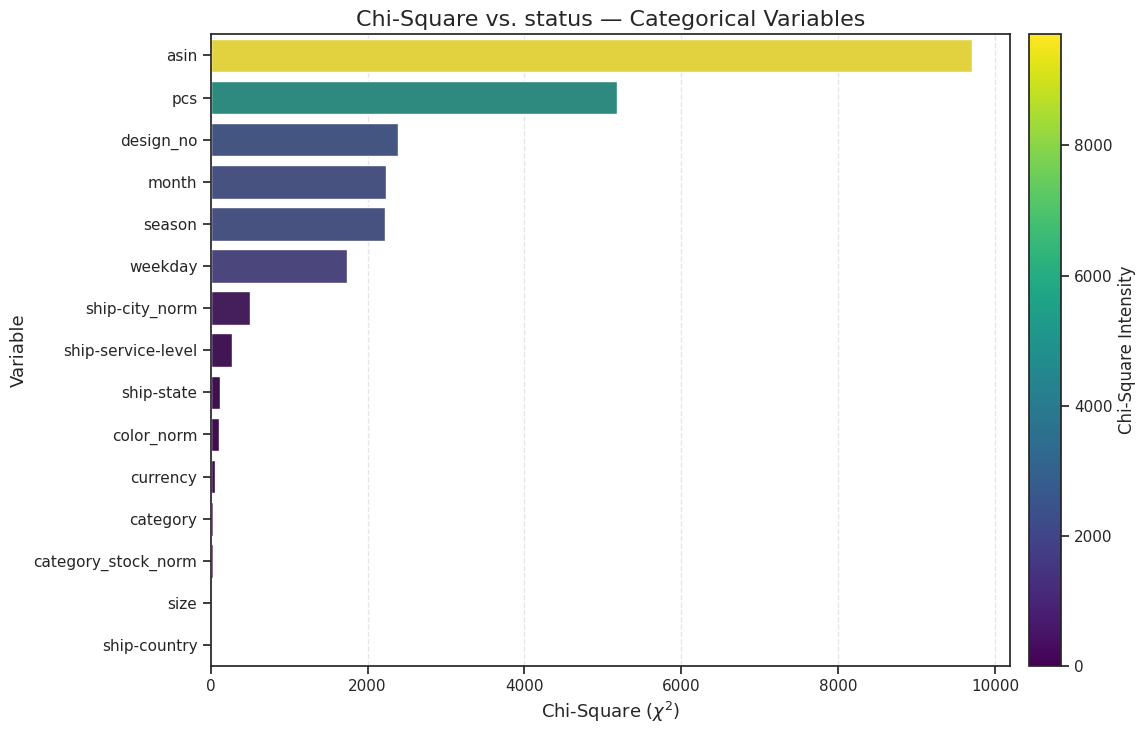

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# ===== Inputs / setup =====
df_to_use = df_cleaned           # use the cleaned DataFrame
target = "status"                # categorical target variable for association testing

# Identify categorical columns (excluding the target itself)
cat_cols = [
    c for c in df_to_use.columns
    if c != target and (
        pd.api.types.is_categorical_dtype(df_to_use[c]) or
        pd.api.types.is_object_dtype(df_to_use[c])
    )
]

results = []

# ===== Chi-square test for each categorical column against the target =====
for col in cat_cols:
    if df_to_use[col].nunique(dropna=True) > 1:  # need at least 2 levels
        contingency = pd.crosstab(df_to_use[col], df_to_use[target], dropna=True)  # contingency table
        if contingency.shape[0] > 1 and contingency.shape[1] > 1:  # valid table (≥2x2)
            chi2_stat, p_val, dof, ex = chi2_contingency(contingency)  # Pearson chi-square
            results.append({"Variable": col, "Chi-Square": chi2_stat, "p_value": p_val})

# ===== Build results table and plot =====
if not results:
    print("No eligible categorical columns for Chi-Square plot.")
else:
    results_df = pd.DataFrame(results)
    results_df = results_df[results_df["Variable"] != target]  # ensure target isn’t plotted as a variable
    results_df.sort_values("Chi-Square", ascending=False, inplace=True, ignore_index=True)

    # ===== Color mapping by chi-square magnitude =====
    norm = plt.Normalize(results_df["Chi-Square"].min(), results_df["Chi-Square"].max())
    cmap = sns.color_palette("viridis", as_cmap=True)  # colormap for bar coloring
    colors = cmap(norm(results_df["Chi-Square"]))

    # ===== Bar chart with gradient coloring =====
    plt.figure(figsize=(12, max(6, 0.5 * len(results_df))))
    sns.barplot(
        data=results_df,
        x="Chi-Square",
        y="Variable",
        palette=colors
    )

    plt.title(f"Chi-Square vs. {target} — Categorical Variables", fontsize=16)
    plt.xlabel(r"Chi-Square ($\chi^2$)", fontsize=13)
    plt.ylabel("Variable", fontsize=13)
    plt.grid(axis="x", linestyle="--", alpha=0.5)

    # === Add a colorbar to indicate intensity ===
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), orientation="vertical", pad=0.02)
    cbar.set_label("Chi-Square Intensity", fontsize=12)

    plt.tight_layout()
    plt.show()


In [44]:
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np

# Assumptions:
# - df_cleaned is your cleaned DataFrame
# - target is a categorical target column (e.g., 'status')
df_to_use = df_cleaned.copy()
target = "status"

# If cat_cols was not defined earlier, auto-detect categorical/object columns (excluding target)
if "cat_cols" not in locals():
    cat_cols = [
        c for c in df_to_use.columns
        if c != target and (
            pd.api.types.is_categorical_dtype(df_to_use[c]) or
            pd.api.types.is_object_dtype(df_to_use[c])
        )
    ]

# Helper: Cramér's V (effect size) with bias correction (Bergsma 2013)
def cramers_v_corrected(confusion: pd.DataFrame) -> float:
    """Compute bias-corrected Cramér's V for any-sized contingency table."""
    chi2, _, _, _ = chi2_contingency(confusion)
    n = confusion.values.sum()
    if n == 0:
        return np.nan
    phi2 = chi2 / n
    r, k = confusion.shape
    # Bias correction
    phi2_corr = max(0, phi2 - (k-1)*(r-1)/(n-1))
    r_corr = r - (r-1)**2/(n-1)
    k_corr = k - (k-1)**2/(n-1)
    denom = min((k_corr-1), (r_corr-1))
    if denom <= 0:
        return np.nan
    return np.sqrt(phi2_corr / denom)

# Collect detailed results
results = []

for col in cat_cols:
    # Skip columns with <2 distinct non-null categories
    if df_to_use[col].nunique(dropna=True) <= 1:
        continue

    # Build contingency table (dropna=True drops NA rows from both variables)
    contingency = pd.crosstab(df_to_use[col], df_to_use[target], dropna=True)

    # Must be at least 2x2 to run chi-square
    if contingency.shape[0] <= 1 or contingency.shape[1] <= 1:
        print(f"Skipping Chi-Square Test for {col}: Not enough groups after dropping NA.")
        continue

    # Chi-square test (note: for 2x2 tables, scipy applies Yates’ continuity correction by default)
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency)

    # Basic diagnostics: flag if any expected count is < 5 (Chi-square assumptions)
    expected_min = expected.min() if expected.size else np.nan
    warn_low_expected = expected_min < 5

    # Effect size
    cramer_v = cramers_v_corrected(contingency)

    # Store summary
    results.append({
        "Variable": col,
        "Chi-Square": chi2_stat,
        "p_value": p_val,
        "dof": dof,
        "min_expected": expected_min,
        "low_expected_flag": warn_low_expected,
        "cramers_v": cramer_v,
        "levels_x": contingency.shape[0],
        "levels_y": contingency.shape[1],
        "n": contingency.values.sum()
    })

    # Optional: verbose printout per variable
    print(f"--- Results for: {col} vs {target} ---")
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"Degrees of freedom  : {dof}")
    print(f"P-value             : {p_val:.10f}")
    print(f"Cramér's V          : {cramer_v:.4f}")
    if warn_low_expected:
        print("Note: At least one expected cell count < 5; consider Fisher’s exact test (for 2x2) or category grouping.")
    print("-" * 60)

# Create a tidy results table (sorted by ascending p-value)
if results:
    results_df = (
        pd.DataFrame(results)
        .sort_values(["p_value", "Chi-Square"], ascending=[True, False])
        .reset_index(drop=True)
    )
    # Show top rows; you can display/save as needed
    print("\n=== Chi-Square Summary (sorted by p-value) ===")
    print(results_df.head(20))
else:
    print("No eligible categorical columns for Chi-Square test.")


--- Results for: ship-service-level vs status ---
Chi-square statistic: 267.7583
Degrees of freedom  : 1
P-value             : 0.0000000000
Cramér's V          : 0.0455
------------------------------------------------------------
--- Results for: category vs status ---
Chi-square statistic: 35.4099
Degrees of freedom  : 3
P-value             : 0.0000000998
Cramér's V          : 0.0159
------------------------------------------------------------
--- Results for: size vs status ---
Chi-square statistic: 8.7301
Degrees of freedom  : 8
P-value             : 0.3655734808
Cramér's V          : 0.0024
Note: At least one expected cell count < 5; consider Fisher’s exact test (for 2x2) or category grouping.
------------------------------------------------------------
--- Results for: asin vs status ---
Chi-square statistic: 9705.6247
Degrees of freedom  : 7189
P-value             : 0.0000000000
Cramér's V          : 0.1397
Note: At least one expected cell count < 5; consider Fisher’s exact test 

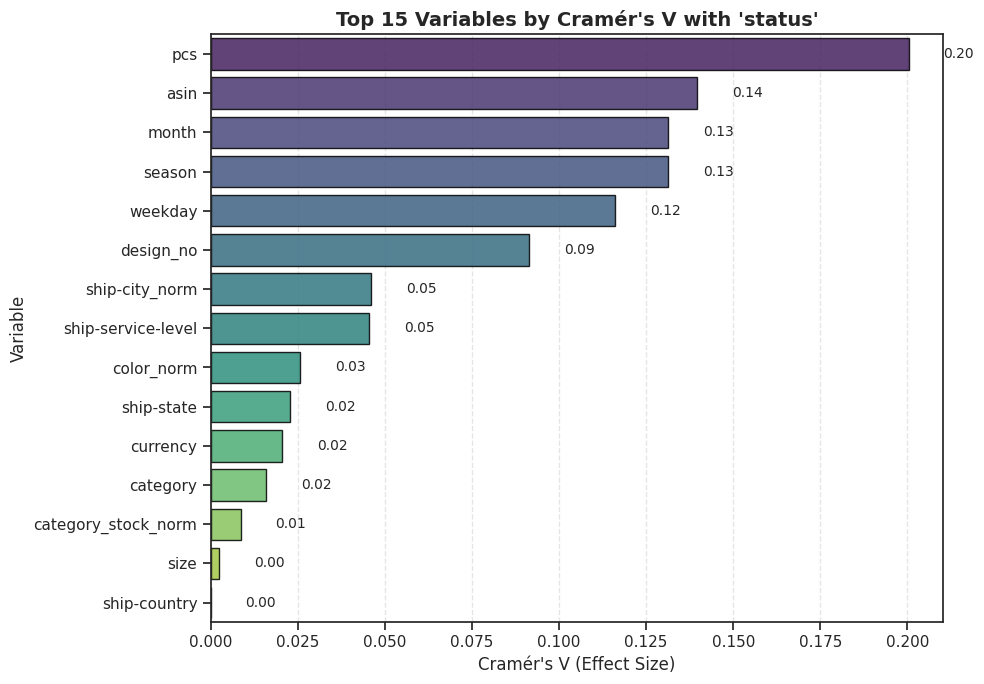

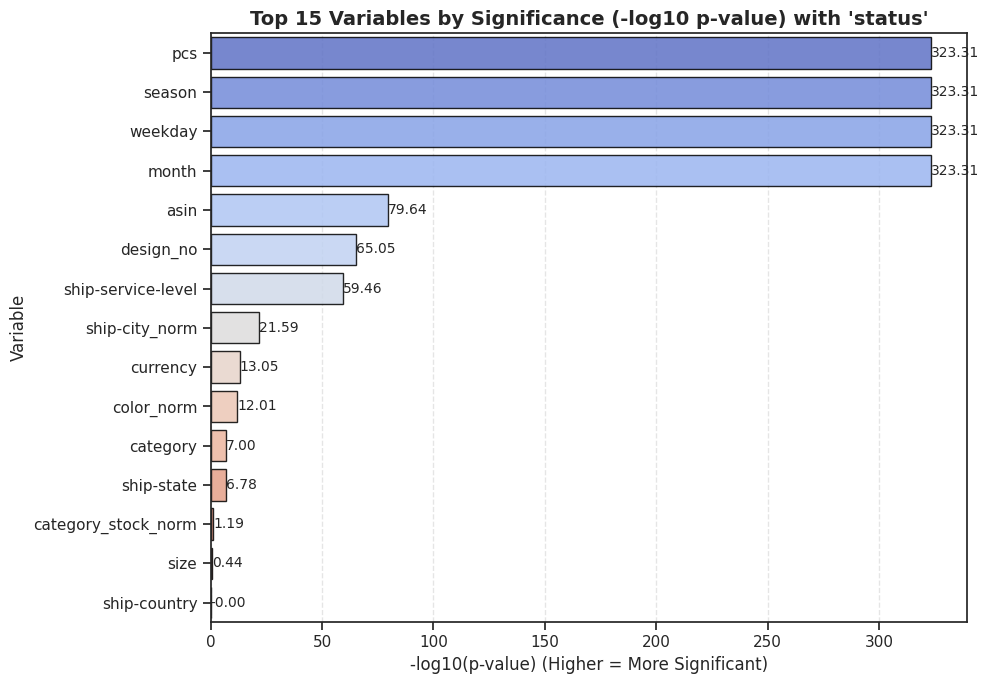

In [45]:
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ===== Base dataset =====
df_to_use = df_cleaned.copy()
target = "status"

# Detect categorical columns if not already defined
if "cat_cols" not in locals():
    cat_cols = [
        c for c in df_to_use.columns
        if c != target and (
            pd.api.types.is_categorical_dtype(df_to_use[c]) or
            pd.api.types.is_object_dtype(df_to_use[c])
        )
    ]

# ===== Function: Cramér's V with bias correction =====
def cramers_v_corrected(confusion: pd.DataFrame) -> float:
    """Compute bias-corrected Cramér's V for any-sized contingency table."""
    chi2, _, _, _ = chi2_contingency(confusion)
    n = confusion.values.sum()
    if n == 0:
        return np.nan
    phi2 = chi2 / n
    r, k = confusion.shape
    phi2_corr = max(0, phi2 - (k - 1) * (r - 1) / (n - 1))
    r_corr = r - (r - 1)**2 / (n - 1)
    k_corr = k - (k - 1)**2 / (n - 1)
    denom = min((k_corr - 1), (r_corr - 1))
    if denom <= 0:
        return np.nan
    return np.sqrt(phi2_corr / denom)

# ===== Chi-square analysis =====
results = []
for col in cat_cols:
    if df_to_use[col].nunique(dropna=True) <= 1:
        continue
    contingency = pd.crosstab(df_to_use[col], df_to_use[target], dropna=True)
    if contingency.shape[0] <= 1 or contingency.shape[1] <= 1:
        continue
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency)
    cramer_v = cramers_v_corrected(contingency)
    results.append({
        "Variable": col,
        "Chi-Square": chi2_stat,
        "p_value": p_val,
        "cramers_v": cramer_v,
    })

# ===== Visualization =====
if not results:
    print("No eligible categorical columns for Chi-Square test.")
else:
    results_df = pd.DataFrame(results).sort_values("p_value").reset_index(drop=True)

    # ===== Bar plot: Cramér's V =====
    top_n = 20
    cramers_plot_df = (
        results_df.dropna(subset=["cramers_v"])
        .sort_values("cramers_v", ascending=False)
        .head(top_n)
    )

    plt.figure(figsize=(10, 7))
    sns.barplot(
        data=cramers_plot_df,
        x="cramers_v",
        y="Variable",
        palette="viridis",
        edgecolor="black",
        alpha=0.85
    )
    plt.title(f"Top {len(cramers_plot_df)} Variables by Cramér's V with '{target}'", fontsize=14, fontweight="bold")
    plt.xlabel("Cramér's V (Effect Size)", fontsize=12)
    plt.ylabel("Variable", fontsize=12)
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    for i, v in enumerate(cramers_plot_df["cramers_v"]):
        plt.text(v + 0.01, i, f"{v:.2f}", va="center", fontsize=10)
    plt.tight_layout()
    plt.show()

    # ===== Bar plot: -log10(p-value) =====
    results_df["_neglog10_p"] = -np.log10(results_df["p_value"].replace(0, np.nextafter(0, 1)))
    pval_plot_df = results_df.sort_values("p_value").head(top_n)

    plt.figure(figsize=(10, 7))
    sns.barplot(
        data=pval_plot_df,
        x="_neglog10_p",
        y="Variable",
        palette="coolwarm",
        edgecolor="black",
        alpha=0.85
    )
    plt.title(f"Top {len(pval_plot_df)} Variables by Significance (-log10 p-value) with '{target}'", fontsize=14, fontweight="bold")
    plt.xlabel("-log10(p-value) (Higher = More Significant)", fontsize=12)
    plt.ylabel("Variable", fontsize=12)
    plt.grid(axis="x", linestyle="--", alpha=0.5)
    for i, v in enumerate(pval_plot_df["_neglog10_p"]):
        plt.text(v + 0.05, i, f"{v:.2f}", va="center", fontsize=10)
    plt.tight_layout()
    plt.show()


Skipping Chi-Square Test for fulfilment: only one category.
--- Results for: ship-service-level vs day ---
Chi-square statistic: 1541.5869
Degrees of freedom  : 30
p-value             : 0.0000000000
------------------------------------------------------------
--- Results for: category vs day ---
Chi-square statistic: 529.2388
Degrees of freedom  : 90
p-value             : 0.0000000000
------------------------------------------------------------
--- Results for: size vs day ---
Chi-square statistic: 655.8928
Degrees of freedom  : 240
p-value             : 0.0000000000
------------------------------------------------------------
Skipping Chi-Square Test for ship-country: only one category.
--- Results for: month vs day ---
Chi-square statistic: 19757.8312
Degrees of freedom  : 90
p-value             : 0.0000000000
------------------------------------------------------------
--- Results for: weekday vs day ---
Chi-square statistic: 187802.3435
Degrees of freedom  : 180
p-value            

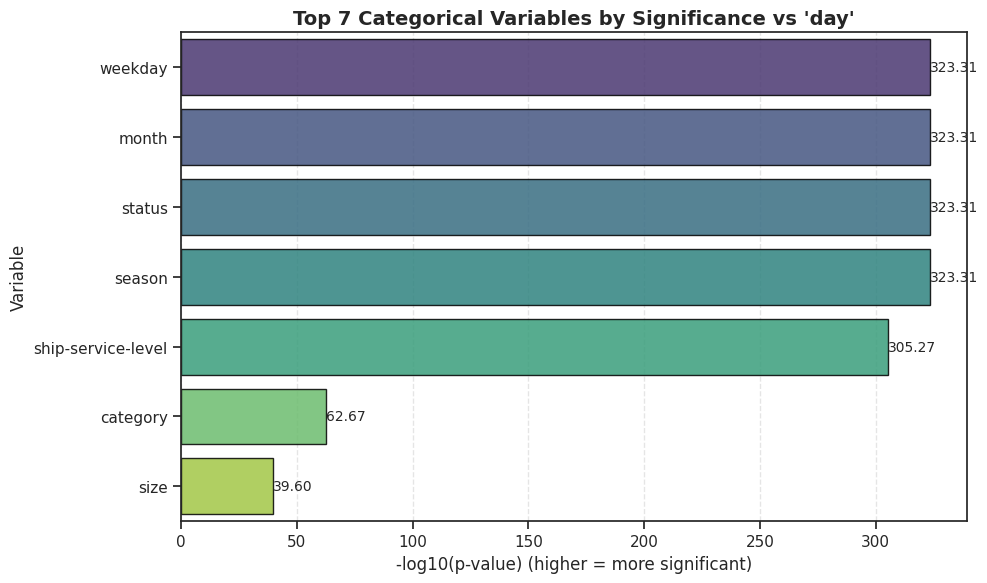

In [46]:
from scipy.stats import chi2_contingency
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assumption: df is your cleaned DataFrame
df_to_use = df.copy()

# Target categorical variable
target = "day"

# Categorical columns (object / category), excluding the target
cat_cols = [
    c for c in df_to_use.select_dtypes(include=["object", "category"]).columns
    if c != target
]

# ==============================================
# 1. Chi-Square Test for Categorical Variables vs Target
# ==============================================
results = []

for col in cat_cols:
    # Skip columns with only one category
    if df_to_use[col].nunique(dropna=True) <= 1:
        print(f"Skipping Chi-Square Test for {col}: only one category.")
        continue

    # Build contingency table between the categorical variable and the target
    contingency = pd.crosstab(df_to_use[col], df_to_use[target], dropna=True)

    # Skip if contingency table is too small (must be at least 2x2)
    if contingency.shape[0] <= 1 or contingency.shape[1] <= 1:
        print(f"Skipping Chi-Square Test for {col}: not enough groups after dropping NA.")
        continue

    # Run Chi-Square test
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency)

    # Save detailed results for later summary / plotting
    results.append({
        "Variable": col,
        "Chi-Square": chi2_stat,
        "p_value": p_val,
        "dof": dof,
        "n": contingency.values.sum()
    })

    # Print detailed results for this variable
    print(f"--- Results for: {col} vs {target} ---")
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"Degrees of freedom  : {dof}")
    print(f"p-value             : {p_val:.10f}")
    print("-" * 60)

# ==============================================
# 2. Text summary table of results
# ==============================================
if not results:
    print("No eligible categorical columns for Chi-Square test.")
else:
    results_df = (
        pd.DataFrame(results)
        .sort_values(["p_value", "Chi-Square"], ascending=[True, False])
        .reset_index(drop=True)
    )

    print("\n=== Chi-Square Summary (sorted by p-value) ===")
    print(results_df.head(20))

    # ==============================================
    # 3. Plot: -log10(p-value) for top variables
    # ==============================================
    top_n = 20

    # Replace p-values equal to 0 by a very small positive number to avoid -log10(0)
    results_df["_neglog10_p"] = -np.log10(
        results_df["p_value"].replace(0, np.nextafter(0, 1))
    )

    plot_df = results_df.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=plot_df,
        x="_neglog10_p",
        y="Variable",
        palette="viridis",
        edgecolor="black",
        alpha=0.85
    )
    plt.title(
        f"Top {len(plot_df)} Categorical Variables by Significance vs '{target}'",
        fontsize=14,
        fontweight="bold"
    )
    plt.xlabel("-log10(p-value) (higher = more significant)", fontsize=12)
    plt.ylabel("Variable", fontsize=12)
    plt.grid(axis="x", linestyle="--", alpha=0.5)

    # Add value labels on the bars
    for i, v in enumerate(plot_df["_neglog10_p"]):
        plt.text(v + 0.05, i, f"{v:.2f}", va="center", fontsize=10)

    plt.tight_layout()
    plt.show()



#Folium Map: Orders by City
🔹 Circle size = Sale amount


In [47]:
# --- Map orders by city for a specific amount ---
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from tqdm import tqdm

# Ensure expected columns exist and are strings (normalize types for grouping and geocoding)
df['ship-city_norm'] = df['ship-city_norm'].astype(str)
df['ship-state'] = df['ship-state'].astype(str)

# === 2) Aggregate sales by state + city ===
# Sum total 'amount' per (ship-state, ship-city_norm) and sort by descending sales
sales_by_city = (
    df.groupby(['ship-state', 'ship-city_norm'], as_index=False)['amount']
    .sum()
    .sort_values('amount', ascending=False)
)

# === 3) Geocode each city to get latitude/longitude (uses OpenStreetMap Nominatim) ===
# Note: Geocoding is rate-limited; for many rows consider caching or batching.
geolocator = Nominatim(user_agent="sales_map_india")
tqdm.pandas()  # enable progress bar for apply

def geocode_location(city, state):
    """Return latitude/longitude for '<city>, <state>, India'; None/None if not found or on error."""
    try:
        loc = geolocator.geocode(f"{city}, {state}, India")
        if loc:
            return pd.Series({'lat': loc.latitude, 'lon': loc.longitude})
    except:
        pass
    return pd.Series({'lat': None, 'lon': None})

# Apply geocoding row-wise with a progress bar
sales_by_city[['lat', 'lon']] = sales_by_city.progress_apply(
    lambda row: geocode_location(row['ship-city_norm'], row['ship-state']), axis=1
)

# === 4) Drop rows where geocoding failed (missing coordinates) ===
sales_by_city = sales_by_city.dropna(subset=['lat', 'lon'])

# === 5) Initialize an India-centered interactive map ===
m = folium.Map(location=[22.0, 78.0], zoom_start=5, tiles='cartodbpositron')

# === 6) Add circle markers sized by relative sales volume ===
# Radius scaled up to 25px max; minimum radius enforced for visibility
for _, row in sales_by_city.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=max(3, row['amount'] / sales_by_city['amount'].max() * 25),
        popup=f"""
        <b>{row['ship-city_norm']}</b>, {row['ship-state']}<br>
        Sales: ₹{row['amount']:.2f}
        """,
        color="blue",
        fill=True,
        fill_color="green",
        fill_opacity=0.6
    ).add_to(m)

# === 7) Save to HTML and return the map object (renders inline in notebooks) ===
m.save("sales_map_india.html")
m


100%|██████████| 315/315 [10:34<00:00,  2.01s/it]


In [48]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from tqdm import tqdm

# === 1) Prepare two subsets ===
promo_df = df[df["has_promotion"] == 1].copy()
no_promo_df = df[df["has_promotion"] == 0].copy()

# Ensure consistent data types
for d in [promo_df, no_promo_df]:
    d["ship-city_norm"] = d["ship-city_norm"].astype(str)
    d["ship-state"] = d["ship-state"].astype(str)

# === 2) Aggregate total amount per city/state for both ===
promo_sales = (
    promo_df.groupby(["ship-state", "ship-city_norm"], as_index=False)["amount"]
    .sum()
    .assign(promo_type="With Promotion")
)
no_promo_sales = (
    no_promo_df.groupby(["ship-state", "ship-city_norm"], as_index=False)["amount"]
    .sum()
    .assign(promo_type="Without Promotion")
)

# Combine both sets for easier handling
all_sales = pd.concat([promo_sales, no_promo_sales])

# === 3) Geocode each city (with progress bar) ===
geolocator = Nominatim(user_agent="sales_promo_map_india")
tqdm.pandas()

def geocode_location(city, state):
    """Return latitude/longitude for '<city>, <state>, India'; None if not found."""
    try:
        loc = geolocator.geocode(f"{city}, {state}, India")
        if loc:
            return pd.Series({"lat": loc.latitude, "lon": loc.longitude})
    except:
        pass
    return pd.Series({"lat": None, "lon": None})

# Only unique cities for geocoding efficiency
unique_locs = all_sales[["ship-city_norm", "ship-state"]].drop_duplicates()
unique_locs[["lat", "lon"]] = unique_locs.progress_apply(
    lambda r: geocode_location(r["ship-city_norm"], r["ship-state"]), axis=1
)

# Merge coordinates back
all_sales = all_sales.merge(unique_locs, on=["ship-city_norm", "ship-state"], how="left")
all_sales = all_sales.dropna(subset=["lat", "lon"])

# === 4) Initialize map ===
m = folium.Map(location=[22.0, 78.0], zoom_start=5, tiles="cartodbpositron")

# Split by promotion type for layered visualization
max_amount = all_sales["amount"].max()

# Add with-promotion points
for _, row in all_sales[all_sales["promo_type"] == "With Promotion"].iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=max(3, row["amount"] / max_amount * 25),
        popup=f"<b>{row['ship-city_norm']}</b>, {row['ship-state']}<br>Promo Sales: ₹{row['amount']:.2f}",
        color="red",
        fill=True,
        fill_color="orange",
        fill_opacity=0.7
    ).add_to(m)

# Add without-promotion points
for _, row in all_sales[all_sales["promo_type"] == "Without Promotion"].iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=max(3, row["amount"] / max_amount * 25),
        popup=f"<b>{row['ship-city_norm']}</b>, {row['ship-state']}<br>Non-Promo Sales: ₹{row['amount']:.2f}",
        color="blue",
        fill=True,
        fill_color="lightblue",
        fill_opacity=0.6
    ).add_to(m)

# === 5) Save to HTML and show ===
m.save("sales_promo_vs_no_promo_map.html")
m


100%|██████████| 315/315 [09:25<00:00,  1.80s/it]


In [49]:
import pandas as pd
import folium
from geopy.geocoders import Nominatim
from tqdm import tqdm

# === 1) Prepare two subsets: Pending vs Not Pending ===
pending_df = df[df["status"] == "Pending"].copy()
not_pending_df = df[df["status"] != "Pending"].copy()

# Ensure consistent data types
for d in [pending_df, not_pending_df]:
    d["ship-city_norm"] = d["ship-city_norm"].astype(str)
    d["ship-state"] = d["ship-state"].astype(str)

# === 2) Aggregate total amount per city/state for both ===
pending_sales = (
    pending_df.groupby(["ship-state", "ship-city_norm"], as_index=False)["amount"]
    .sum()
    .assign(status_type="Pending")
)

not_pending_sales = (
    not_pending_df.groupby(["ship-state", "ship-city_norm"], as_index=False)["amount"]
    .sum()
    .assign(status_type="Not Pending")
)

# Combine both sets for easier handling
all_status_sales = pd.concat([pending_sales, not_pending_sales], ignore_index=True)

# === 3) Geocode each city (with progress bar) ===
geolocator = Nominatim(user_agent="sales_status_map_india")
tqdm.pandas()

def geocode_location(city, state):
    """Return latitude/longitude for '<city>, <state>, India'; None if not found."""
    try:
        loc = geolocator.geocode(f"{city}, {state}, India")
        if loc:
            return pd.Series({"lat": loc.latitude, "lon": loc.longitude})
    except:
        pass
    return pd.Series({"lat": None, "lon": None})

# Only unique cities for geocoding efficiency
unique_locs = all_status_sales[["ship-city_norm", "ship-state"]].drop_duplicates()
unique_locs[["lat", "lon"]] = unique_locs.progress_apply(
    lambda r: geocode_location(r["ship-city_norm"], r["ship-state"]), axis=1
)

# Merge coordinates back
all_status_sales = all_status_sales.merge(
    unique_locs, on=["ship-city_norm", "ship-state"], how="left"
)
all_status_sales = all_status_sales.dropna(subset=["lat", "lon"])

# === 4) Initialize map ===
m = folium.Map(location=[22.0, 78.0], zoom_start=5, tiles="cartodbpositron")

# Scale radius by max amount
max_amount = all_status_sales["amount"].max()

# Add Pending points
for _, row in all_status_sales[all_status_sales["status_type"] == "Pending"].iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=max(3, row["amount"] / max_amount * 25),
        popup=(
            f"<b>{row['ship-city_norm']}</b>, {row['ship-state']}"
            f"<br>Status: Pending<br>Amount: ₹{row['amount']:.2f}"
        ),
        color="red",
        fill=True,
        fill_color="orange",
        fill_opacity=0.7
    ).add_to(m)

# Add Not-Pending points
for _, row in all_status_sales[all_status_sales["status_type"] == "Not Pending"].iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=max(3, row["amount"] / max_amount * 25),
        popup=(
            f"<b>{row['ship-city_norm']}</b>, {row['ship-state']}"
            f"<br>Status: Not Pending<br>Amount: ₹{row['amount']:.2f}"
        ),
        color="blue",
        fill=True,
        fill_color="lightblue",
        fill_opacity=0.6
    ).add_to(m)

# === 5) Save to HTML and show ===
m.save("sales_status_pending_vs_not_pending_map.html")
m


100%|██████████| 315/315 [09:35<00:00,  1.83s/it]
